# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### 1. Initial Data Cleaning
- Step 1: due to the large volume of original data, load the first 100000 observations of the population data before building an ETL function that cleans the real data.

In [6]:
# load in the first 100K observations of the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';', nrows= 100000)


In [3]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


## Part 1: Data Mining
- Develop a data cleaning pipeline using the azdias data

First, load the dataset of attribute info

In [4]:
## the attributes data
attributes = pd.read_excel('DIAS Attributes - Values 2017.xlsx', usecols = [1,2,3,4])
attributes.fillna(method = 'ffill', inplace = True)
attributes.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly


#### Missing Values
According to the attribute values table, some missing values are not encoded as NA. They have other values like -1.

In [5]:
## to take care of missing values - the word 'unknown'
attr_missing = attributes[attributes['Meaning'] == 'unknown']
attr_missing.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown
48,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown


In [6]:
unknown_values = []
for val in attr_missing.Value:
    ## evaluate whether missing 'value' is an integer (one digit)
    if isinstance(val, int):
        unknown_values.append([val])
    ## evaluate whether attribute has more than one value (a string object in the dataframe)
    elif isinstance(val, str):
        split_list = val.split(',')
        int_list = [int(x) for x in split_list]
        unknown_values.append(int_list)

unknown_dict = {}
for attr, value_list in zip(attr_missing.Attribute, unknown_values):
    unknown_dict[attr] = value_list
    
unknown_dict['ALTERSKATEGORIE_FEIN'] = [0]
unknown_dict['GEBURTSJAHR'] = [0]

In [7]:
unknown_dict

{'AGER_TYP': [-1],
 'ALTERSKATEGORIE_GROB': [-1, 0],
 'ANREDE_KZ': [-1, 0],
 'BALLRAUM': [-1],
 'BIP_FLAG': [-1],
 'CAMEO_DEUG_2015': [-1],
 'CAMEO_DEUINTL_2015': [-1],
 'CJT_GESAMTTYP': [0],
 'D19_KK_KUNDENTYP': [-1],
 'EWDICHTE': [-1],
 'FINANZTYP': [-1],
 'FINANZ_ANLEGER': [-1],
 'FINANZ_HAUSBAUER': [-1],
 'FINANZ_MINIMALIST': [-1],
 'FINANZ_SPARER': [-1],
 'FINANZ_UNAUFFAELLIGER': [-1],
 'FINANZ_VORSORGER': [-1],
 'GEBAEUDETYP': [-1, 0],
 'GEOSCORE_KLS7': [-1, 0],
 'HAUSHALTSSTRUKTUR': [-1, 0],
 'HEALTH_TYP': [-1],
 'HH_EINKOMMEN_SCORE': [-1, 0],
 'INNENSTADT': [-1],
 'KBA05_ALTER1': [-1, 9],
 'KBA05_ALTER2': [-1, 9],
 'KBA05_ALTER3': [-1, 9],
 'KBA05_ALTER4': [-1, 9],
 'KBA05_ANHANG': [-1, 9],
 'KBA05_ANTG1': [-1],
 'KBA05_ANTG2': [-1],
 'KBA05_ANTG3': [-1],
 'KBA05_ANTG4': [-1],
 'KBA05_AUTOQUOT': [-1, 9],
 'KBA05_BAUMAX': [-1, 0],
 'KBA05_CCM1': [-1, 9],
 'KBA05_CCM2': [-1, 9],
 'KBA05_CCM3': [-1, 9],
 'KBA05_CCM4': [-1, 9],
 'KBA05_DIESEL': [-1, 9],
 'KBA05_FRAU': [-1, 9],
 'KB

In [8]:
azdias_clean = azdias.copy()
azdias_clean.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [9]:
## use dictionary to replace missing values with NaN
for key in unknown_dict:
    for x in unknown_dict[key]:
        try:
            azdias_clean[key] = azdias_clean[key].replace(x, np.nan)
            
        except:
            ## print columns that are in the attribute list but not on the data
            print(key)
            continue

BIP_FLAG
CAMEO_DEUINTL_2015
D19_KK_KUNDENTYP
GEOSCORE_KLS7
GEOSCORE_KLS7
HAUSHALTSSTRUKTUR
HAUSHALTSSTRUKTUR
KBA13_CCM_1400_2500
SOHO_FLAG
WACHSTUMSGEBIET_NB
WACHSTUMSGEBIET_NB


In [10]:
azdias_clean.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,NaN,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [11]:
## how many missing values are there?

attr_miss = pd.DataFrame(azdias_clean.isnull().mean() * 100, columns = ['pct_miss'])
attr_miss.head()

,pct_miss
LNR,0.000
AGER_TYP,76.222
AKT_DAT_KL,8.385
ALTER_HH,8.385
ALTER_KIND1,90.908


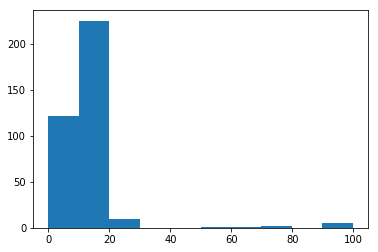

In [12]:
plt.hist(attr_miss['pct_miss']);

- Drop all columns with over 40% of data missing

In [13]:
miss_cols = attr_miss[attr_miss['pct_miss'] > 40]
drop_cols = miss_cols.index
drop_cols

Index(['AGER_TYP', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'EXTSEL992', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ'],
      dtype='object')

In [14]:
azdias_clean.drop(columns = list(drop_cols), inplace = True)
azdias_clean.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [15]:
obs_miss = pd.DataFrame(azdias_clean.isnull().mean(axis = 1) * 100, columns = ['pct_miss'])
obs_miss.head()


,pct_miss
0,69.747899
1,2.521008
2,0.000000
3,1.120448
4,0.000000


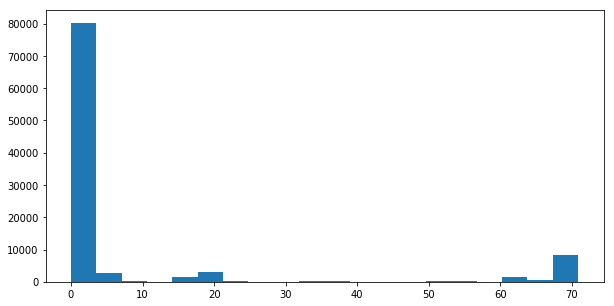

In [16]:
plt.figure(figsize = (10, 5))
plt.hist(obs_miss['pct_miss'], bins = 20);

In [17]:
obs_miss.shape

(100000, 1)

In [18]:
(obs_miss['pct_miss'] > 25).sum()

11881

In [19]:
## how many observations contain more than half missing data?
(obs_miss['pct_miss'] > 50).sum() / azdias_clean.shape[0]

0.11246

In [20]:
miss_50 = obs_miss[obs_miss['pct_miss'] > 50]
miss_50_idxs = list(miss_50.index)

In [21]:
len(miss_50_idxs)

11246

In [22]:
azdias_clean.drop(index= miss_50_idxs, inplace = True)
azdias_clean.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,910220,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
5,910244,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1


#### Categorical Variables

In [23]:
## investigate the datatypes
azdias_types = pd.DataFrame(azdias_clean.dtypes, columns = ['dtype'])

## get categorical variables
azdias_objects = azdias_types[azdias_types['dtype'] == 'object']
cat_variables = azdias_objects.index.tolist()

In [24]:
azdias_cat = azdias_clean[cat_variables]
azdias_cat.head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
1,8A,8,51,NaN,1992-02-10 00:00:00,W
2,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W
5,8C,8,54,D19_ENERGIE,1992-02-12 00:00:00,W


In [25]:
azdias_cat.nunique()

CAMEO_DEU_2015                45
CAMEO_DEUG_2015               19
CAMEO_INTL_2015               43
D19_LETZTER_KAUF_BRANCHE      35
EINGEFUEGT_AM               2467
OST_WEST_KZ                    2
dtype: int64

- `CAMEO_DEU_2015` and `CAMEO_INTL_2015` could be split in two and dummied - consult my previous project or feature information
- `CAMEO_DEUG_2015` could be converted into integers
- `EINGEFUEGT_AM` should be dropped as it contains dates and does not seem important
- `D19_LETZTER_KAUF_BRANCHE` should be dropped since there is information about D19 features and this one is not in the feature dictionary and it does not contain entries similar to any of the D19 features.
- `OST_WEST_KZ` should be dummied (W = 1, O = 0)

In [26]:
## split into wealth and life stage
azdias_clean['CAMEO_DEU_2015'] = azdias_clean['CAMEO_DEU_2015'].replace('XX', np.nan)
azdias_clean['WEALTH_DEU_2015'] = azdias_clean['CAMEO_DEU_2015'].str[0]
azdias_clean['LIFE_STAGE_DEU_2015'] = azdias_clean['CAMEO_DEU_2015'].str[1]

azdias_clean.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,WEALTH_DEU_2015,LIFE_STAGE_DEU_2015
1,910220,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,...,11.0,10.0,3.0,9.0,4.0,5,2,1,8,A
2,910225,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,9.0,6.0,3.0,9.0,2.0,5,2,3,4,C
3,910226,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,10.0,11.0,NaN,9.0,7.0,3,2,4,2,A
4,910241,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,...,5.0,4.0,2.0,9.0,3.0,4,1,3,6,B
5,910244,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,...,7.0,4.0,6.0,9.0,7.0,4,2,1,8,C


In [27]:
## replace 'X' with NaN
azdias_clean['CAMEO_INTL_2015'] = azdias_clean['CAMEO_INTL_2015'].replace('XX', np.nan)
azdias_clean['WEALTH_INTL_2015'] = azdias_clean['CAMEO_INTL_2015'].astype(str).str[0]
azdias_clean['WEALTH_INTL_2015'] = azdias_clean['WEALTH_INTL_2015'].replace('n', np.nan)

azdias_clean['LIFE_STAGE_INTL_2015'] = azdias_clean['CAMEO_INTL_2015'].astype(str).str[1]
azdias_clean['LIFE_STAGE_INTL_2015'] = azdias_clean['LIFE_STAGE_INTL_2015'].replace('a', np.nan)
azdias_clean.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,WEALTH_DEU_2015,LIFE_STAGE_DEU_2015,WEALTH_INTL_2015,LIFE_STAGE_INTL_2015
1,910220,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,...,3.0,9.0,4.0,5,2,1,8,A,5,1
2,910225,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,3.0,9.0,2.0,5,2,3,4,C,2,4
3,910226,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,NaN,9.0,7.0,3,2,4,2,A,1,2
4,910241,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,...,2.0,9.0,3.0,4,1,3,6,B,4,3
5,910244,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,...,6.0,9.0,7.0,4,2,1,8,C,5,4


In [28]:

## replace value X for NaN and covert to float
azdias_clean['CAMEO_DEUG_2015'] = azdias_clean['CAMEO_DEUG_2015'].replace('X', np.nan)
azdias_clean['CAMEO_DEUG_2015'] = azdias_clean['CAMEO_DEUG_2015'].astype(float)

azdias_clean.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,WEALTH_DEU_2015,LIFE_STAGE_DEU_2015,WEALTH_INTL_2015,LIFE_STAGE_INTL_2015
1,910220,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,...,3.0,9.0,4.0,5,2,1,8,A,5,1
2,910225,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,3.0,9.0,2.0,5,2,3,4,C,2,4
3,910226,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,NaN,9.0,7.0,3,2,4,2,A,1,2
4,910241,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,...,2.0,9.0,3.0,4,1,3,6,B,4,3
5,910244,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,...,6.0,9.0,7.0,4,2,1,8,C,5,4


- Modify the `PRAEGENDE_JUGENDJAHRE` feature such that it contains a person's decade, 'avantgarde' and 'mainstream'

In [29]:
# temporally change nan values to 0 so that a for loop changes it back
azdias_clean['PRAEGENDE_JUGENDJAHRE'] = azdias_clean['PRAEGENDE_JUGENDJAHRE'].fillna(0)
decades_p_j = {0: np.nan, 1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60,
               7: 60, 8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13:80, 14:90, 15:90}

## create decade (interval), movement (binary)
decade = []
for x in azdias_clean['PRAEGENDE_JUGENDJAHRE']:
    decade.append(decades_p_j[x])

## add decade variable to dataframe
azdias_clean['DECADE'] = decade

## replace missing values for most common values
decade_mode = azdias_clean['DECADE'].mode()[0]
print("the most common decade: {}".format(decade_mode))

azdias_clean['DECADE'] = azdias_clean['DECADE'].replace(np.nan, decade_mode).astype(str)

azdias_clean.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,WEALTH_DEU_2015,LIFE_STAGE_DEU_2015,WEALTH_INTL_2015,LIFE_STAGE_INTL_2015,DECADE
1,910220,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,...,9.0,4.0,5,2,1,8,A,5,1,90.0
2,910225,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,9.0,2.0,5,2,3,4,C,2,4,90.0
3,910226,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,9.0,7.0,3,2,4,2,A,1,2,70.0
4,910241,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,...,9.0,3.0,4,1,3,6,B,4,3,70.0
5,910244,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,...,9.0,7.0,4,2,1,8,C,5,4,50.0


In [30]:
# variable: dimension - list of values
## Movement - Mainstream: [1, 3, 5, 8, 10, 12, 14]
## Movement - Avantgarde: [2, 4, 6, 7, 9, 11, 13, 15]

mainstream = [1, 3, 5, 8, 10, 12, 14]
avantgarde = [2, 4, 6, 7, 9, 11, 13, 15]

movement = [] ## movement -> 1: mainstream, 0: avantgarde
for x in azdias_clean['PRAEGENDE_JUGENDJAHRE']:
    if x in mainstream:
        movement.append(1)
    elif x in avantgarde:
        movement.append(0)
    else:
        movement.append(np.nan)
        
azdias_clean['MOVEMENT_MAINSTREAM'] = movement
azdias_clean.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,WEALTH_DEU_2015,LIFE_STAGE_DEU_2015,WEALTH_INTL_2015,LIFE_STAGE_INTL_2015,DECADE,MOVEMENT_MAINSTREAM
1,910220,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,...,4.0,5,2,1,8,A,5,1,90.0,1.0
2,910225,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,2.0,5,2,3,4,C,2,4,90.0,0.0
3,910226,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,7.0,3,2,4,2,A,1,2,70.0,1.0
4,910241,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,...,3.0,4,1,3,6,B,4,3,70.0,1.0
5,910244,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,...,7.0,4,2,1,8,C,5,4,50.0,1.0


In [31]:
## drop the variable
azdias_clean.drop(columns = ['PRAEGENDE_JUGENDJAHRE', 'D19_LETZTER_KAUF_BRANCHE', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015', 'EINGEFUEGT_AM'], inplace = True)
azdias_clean.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,WEALTH_DEU_2015,LIFE_STAGE_DEU_2015,WEALTH_INTL_2015,LIFE_STAGE_INTL_2015,DECADE,MOVEMENT_MAINSTREAM
1,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,4.0,5,2,1,8,A,5,1,90.0,1.0
2,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,2.0,5,2,3,4,C,2,4,90.0,0.0
3,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,7.0,3,2,4,2,A,1,2,70.0,1.0
4,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,3.0,4,1,3,6,B,4,3,70.0,1.0
5,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,...,7.0,4,2,1,8,C,5,4,50.0,1.0


#### Additional Variables
- Investigate `MIN_GEBAEUDEJAHR`, `KBA13_ANZAHL_PKW`
    - Drop `MIN_GEBAEUDEJAHR`
    - Keep `KBA13_ANZAHL_PKW`


In [ ]:
azdias_clean.drop(columns = ['MIN_GEBAEUDEJAHR'], inplace = True)

In [ ]:
mean_PKW = round(azdias_clean['KBA13_ANZAHL_PKW'].mean())
azdias_clean['KBA13_ANZAHL_PKW'] = azdias_clean['KBA13_ANZAHL_PKW'].replace(np.nan, mean_PKW)
azdias_clean.head()

### Make Dummy Variables

In [35]:
## make dummy variables

azdias_clean_dum = pd.get_dummies(azdias_clean, drop_first= True)

azdias_clean_dum.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,LIFE_STAGE_INTL_2015_2,LIFE_STAGE_INTL_2015_3,LIFE_STAGE_INTL_2015_4,LIFE_STAGE_INTL_2015_5,OST_WEST_KZ_W,DECADE_50.0,DECADE_60.0,DECADE_70.0,DECADE_80.0,DECADE_90.0
1,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,0,0,0,0,1,0,0,0,0,1
2,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,0,0,1,0,1,0,0,0,0,1
3,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,1,0,0,0,1,0,0,1,0,0
4,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,0,1,0,0,1,0,0,1,0,0
5,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,...,0,0,1,0,1,1,0,0,0,0


In [36]:
azdias_clean_dum.shape

(88754, 378)

### 2. Cleaning Pipeline

In [37]:
def clean_data(df, drop_rows = True):
    
    ## 1 - load the attributes data
    print('Step 1 of 6')
    attributes = pd.read_excel('DIAS Attributes - Values 2017.xlsx', usecols = [1,2,3,4])
    ## fill in missing values
    attributes.fillna(method = 'ffill', inplace = True)
    
    ## get unknown values from the attributes table
    attr_missing = attributes[attributes['Meaning'] == 'unknown']
    
    ## 2 - Modify missing values
    print('Step 2 of 6')
    unknown_values = []
    for val in attr_missing.Value:
        ## evaluate whether missing 'value' is an integer (one digit)
        if isinstance(val, int):
            unknown_values.append([val])
        ## evaluate whether attribute has more than one value (a string object in the dataframe)
        elif isinstance(val, str):
            split_list = val.split(',')
            int_list = [int(x) for x in split_list]
            unknown_values.append(int_list)
            
    ## create dictionary of missing values
    unknown_dict = {}
    for attr, value_list in zip(attr_missing.Attribute, unknown_values):
        unknown_dict[attr] = value_list
        
    ## additional variable for NaN value
    unknown_dict['ALTERSKATEGORIE_FEIN'] = [0]
    unknown_dict['GEBURTSJAHR'] = [0]
        
    ## use dictionary to replace missing values with NaN
    df_clean = df.copy()
    df_clean.set_index('LNR', inplace = True)
    
    for key in unknown_dict:
        for x in unknown_dict[key]:
            try:
                df_clean[key] = df_clean[key].replace(x, np.nan)

            except:
                ## move on for columns that are in the attribute list but not on the data
                continue
    
    ## 3 - Handle missing values
    print('Step 3 of 6')
    ## list columns by missing data percentage
    attr_miss = pd.DataFrame(df_clean.isnull().mean() * 100, columns = ['pct_miss'])
    miss_cols = attr_miss[attr_miss['pct_miss'] > 40].index
    
    ## drop columns with over 40% data missing
    df_clean = df_clean.drop(columns = list(miss_cols))  


    if drop_rows:
        
        ## list rows by missing data percentage
        miss_obs = pd.DataFrame(df_clean.isnull().mean(axis = 1) * 100, columns = ['pct_miss'])
        
        ## rows that have over half of data missing
        miss_50 = miss_obs[miss_obs['pct_miss'] > 50]

        ## drop the listed rows
        df_clean = df_clean.drop(index= list(miss_50.index))
        
    else:
        pass
    
    
    ## 4 - Modify categorical variables
    print('Step 4 of 6')
    df_clean['CAMEO_DEU_2015'] = df_clean['CAMEO_DEU_2015'].replace('XX', np.nan)
    df_clean['WEALTH_DEU_2015'] = df_clean['CAMEO_DEU_2015'].str[0]
    df_clean['LIFE_STAGE_DEU_2015'] = df_clean['CAMEO_DEU_2015'].str[1]
    
    ## replace 'X' with NaN
    df_clean['CAMEO_INTL_2015'] = df_clean['CAMEO_INTL_2015'].replace('XX', np.nan)
    df_clean['WEALTH_INTL_2015'] = df_clean['CAMEO_INTL_2015'].astype(str).str[0]
    df_clean['WEALTH_INTL_2015'] = df_clean['WEALTH_INTL_2015'].replace('n', np.nan)

    df_clean['LIFE_STAGE_INTL_2015'] = df_clean['CAMEO_INTL_2015'].astype(str).str[1]
    df_clean['LIFE_STAGE_INTL_2015'] = df_clean['LIFE_STAGE_INTL_2015'].replace('a', np.nan)
    
    ## replace value X for NaN and covert to float
    df_clean['CAMEO_DEUG_2015'] = df_clean['CAMEO_DEUG_2015'].replace('X', np.nan)
    df_clean['CAMEO_DEUG_2015'] = df_clean['CAMEO_DEUG_2015'].astype(float)
    
    ## 5 - Modify other variables
    print('Step 5 of 6')
    # temporally change nan values to 0 so that a for loop changes it back
    df_clean['PRAEGENDE_JUGENDJAHRE'] = df_clean['PRAEGENDE_JUGENDJAHRE'].fillna(0)
    decades_p_j = {0: np.nan, 1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60,
                   7: 60, 8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13:80, 14:90, 15:90}

    ## create decade (interval), movement (binary)
    decade = []
    for x in df_clean['PRAEGENDE_JUGENDJAHRE']:
        decade.append(decades_p_j[x])

    ## add decade variable to dataframe
    df_clean['DECADE'] = decade
    
    ## replace DECADE missing values for most common value
    decade_mode = df_clean['DECADE'].mode()[0]

    ## convert DECADE to object
    df_clean['DECADE'] = df_clean['DECADE'].replace(np.nan, decade_mode).astype(str)
    
    mainstream = [1, 3, 5, 8, 10, 12, 14]
    avantgarde = [2, 4, 6, 7, 9, 11, 13, 15]

    movement = [] ## movement -> 1: mainstream, 0: avantgarde
    for x in df_clean['PRAEGENDE_JUGENDJAHRE']:
        if x in mainstream:
            movement.append(1)
        elif x in avantgarde:
            movement.append(0)
        else:
            movement.append(np.nan)

    df_clean['MOVEMENT_MAINSTREAM'] = movement
    
    ## drop variables
    df_clean = df_clean.drop(columns = ['MIN_GEBAEUDEJAHR', 'D19_LETZTER_KAUF_BRANCHE', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015', 'EINGEFUEGT_AM', 'PRAEGENDE_JUGENDJAHRE'])
    
    mean_PKW = round(df_clean['KBA13_ANZAHL_PKW'].mean())
    df_clean['KBA13_ANZAHL_PKW'] = df_clean['KBA13_ANZAHL_PKW'].replace(np.nan, mean_PKW)
    

    

    ## 6 - dummy variables
    print('Step 6 of 6')

    df_final = pd.get_dummies(df_clean, drop_first= True)
    
    
    return df_final
    
    
    

In [38]:
azdias_cleaned = clean_data(azdias)
azdias_cleaned.head()

Step 1 of 7
Step 2 of 7
Step 3 of 7
Step 4 of 7
Step 5 of 7
Step 6 of 7
Step 7 of 7


,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,LIFE_STAGE_INTL_2015_2,LIFE_STAGE_INTL_2015_3,LIFE_STAGE_INTL_2015_4,LIFE_STAGE_INTL_2015_5,OST_WEST_KZ_W,DECADE_50.0,DECADE_60.0,DECADE_70.0,DECADE_80.0,DECADE_90.0
1,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,0,0,0,0,1,0,0,0,0,1
2,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,0,0,1,0,1,0,0,0,0,1
3,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,1,0,0,0,1,0,0,1,0,0
4,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,0,1,0,0,1,0,0,1,0,0
5,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,...,0,0,1,0,1,1,0,0,0,0


In [39]:
azdias_clean_dum.equals(azdias_cleaned)

True

In [40]:
## load the full datasets
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [41]:
## clean the data
azdias_cleaned = clean_data(azdias)


Step 1 of 7
Step 2 of 7
Step 3 of 7
Step 4 of 7
Step 5 of 7
Step 6 of 7
Step 7 of 7


In [42]:
azdias_cleaned.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,LIFE_STAGE_INTL_2015_2,LIFE_STAGE_INTL_2015_3,LIFE_STAGE_INTL_2015_4,LIFE_STAGE_INTL_2015_5,OST_WEST_KZ_W,DECADE_50.0,DECADE_60.0,DECADE_70.0,DECADE_80.0,DECADE_90.0
1,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,0,0,0,0,1,0,0,0,0,1
2,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,0,0,1,0,1,0,0,0,0,1
3,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,1,0,0,0,1,0,0,1,0,0
4,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,0,1,0,0,1,0,0,1,0,0
5,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,...,0,0,1,0,1,1,0,0,0,0


In [43]:
## load costumers data
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [44]:
## clean the customers data
customers_cleaned = clean_data(customers)
customers_cleaned.head()

Step 1 of 7
Step 2 of 7
Step 3 of 7
Step 4 of 7
Step 5 of 7
Step 6 of 7
Step 7 of 7


,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,LIFE_STAGE_INTL_2015_2,LIFE_STAGE_INTL_2015_3,LIFE_STAGE_INTL_2015_4,LIFE_STAGE_INTL_2015_5,OST_WEST_KZ_W,DECADE_50.0,DECADE_60.0,DECADE_70.0,DECADE_80.0,DECADE_90.0
0,1.0,10.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,...,0,1,0,0,1,1,0,0,0,0
2,1.0,6.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,...,0,0,1,0,1,1,0,0,0,0
3,1.0,8.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,0,1,0,1,0,0,0,0,0
4,1.0,20.0,14.0,7.0,0.0,0.0,4.0,7.0,0.0,3.0,...,0,0,0,0,1,0,0,1,0,0
5,1.0,11.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,3.0,...,0,0,1,0,1,1,0,0,0,0


In [45]:
## save the cleaned datasets as CSV files
azdias_cleaned.to_csv('Udacity_AZDIAS_Cleaned.csv', index= False)
customers_cleaned.to_csv('Udacity_CUSTOMERS_Cleaned.csv', index= False)

## Part 2: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Import Packages and Cleaned Data
Since the population data is very large, the process of determining a number of cluster would incvole

In [3]:
## import Part 2 packages
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score


In [4]:
## load cleaned data
azdias = pd.read_csv('Udacity_AZDIAS_Cleaned.csv', index_col = 'LNR')
azdias.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,WEALTH_INTL_2015_5,LIFE_STAGE_INTL_2015_2,LIFE_STAGE_INTL_2015_3,LIFE_STAGE_INTL_2015_4,LIFE_STAGE_INTL_2015_5,DECADE_50.0,DECADE_60.0,DECADE_70.0,DECADE_80.0,DECADE_90.0
LNR,,,,,,,,,,,,,,,,,,,,,
910220,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,1,0,0,0,0,0,0,0,0,1
910225,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,0,0,0,1,0,0,0,0,0,1
910226,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,0,1,0,0,0,0,0,1,0,0
910241,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,0,0,1,0,0,0,0,1,0,0
910244,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,...,1,0,0,1,0,1,0,0,0,0


In [5]:
customers = pd.read_csv('Udacity_CUSTOMERS_Cleaned.csv', index_col = 'LNR')
customers.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,WEALTH_INTL_2015_5,LIFE_STAGE_INTL_2015_2,LIFE_STAGE_INTL_2015_3,LIFE_STAGE_INTL_2015_4,LIFE_STAGE_INTL_2015_5,DECADE_50.0,DECADE_60.0,DECADE_70.0,DECADE_80.0,DECADE_90.0
LNR,,,,,,,,,,,,,,,,,,,,,
9626,1.0,10.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,...,0,0,1,0,0,1,0,0,0,0
143872,1.0,6.0,NaN,1.0,0.0,0.0,1.0,1.0,0.0,3.0,...,0,0,0,1,0,1,0,0,0,0
143873,1.0,8.0,8.0,0.0,NaN,0.0,0.0,1.0,0.0,1.0,...,0,0,0,1,0,0,0,0,0,0
143874,1.0,20.0,14.0,7.0,0.0,0.0,4.0,7.0,0.0,3.0,...,0,0,0,0,0,0,0,1,0,0
143888,1.0,11.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,3.0,...,0,0,0,1,0,1,0,0,0,0


In [6]:
## sample the population dataset to the size of customers data in order to get an optimal number of clusters
## random state
rs = 0
azdias_sample = azdias.sample(n = round(azdias.shape[0] * 0.25), random_state = rs)
azdias_sample.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,WEALTH_INTL_2015_5,LIFE_STAGE_INTL_2015_2,LIFE_STAGE_INTL_2015_3,LIFE_STAGE_INTL_2015_4,LIFE_STAGE_INTL_2015_5,DECADE_50.0,DECADE_60.0,DECADE_70.0,DECADE_80.0,DECADE_90.0
LNR,,,,,,,,,,,,,,,,,,,,,
494954,1.0,15.0,15.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0,...,0,0,0,1,0,0,0,0,1,0
581953,1.0,17.0,17.0,1.0,0.0,2.0,2.0,1.0,0.0,2.0,...,0,0,0,1,0,0,0,0,0,1
729395,1.0,0.0,11.0,2.0,0.0,1.0,2.0,2.0,0.0,2.0,...,0,0,1,0,0,0,1,0,0,0
927066,6.0,15.0,15.0,3.0,0.0,0.0,1.0,2.0,0.0,2.0,...,0,1,0,0,0,0,0,0,1,0
493961,4.0,19.0,19.0,9.0,0.0,0.0,0.0,6.0,0.0,3.0,...,1,0,0,0,0,0,0,0,0,1


In [7]:
azdias_sample.shape

(197813, 376)

#### Demographics Principal Component Interpretations

In [242]:
def pca_results(pc, df = azdias_sample, pct_var = 0.85, return_columns = False, plot_pca = False):
    """
    INPUT: principal component number, data to process (sampled demographics),
    percent of variance explained for optimal number of components, 
    and whether to return a list of the columns with most variance
    
    OUTPUT: Plot of the features with the largest principal component weights for the given component number
    as well as a list of the features in the plot
    """
    
    ## 1- standardize the data
    imp = SimpleImputer(strategy = 'mean')
    df_imp = imp.fit_transform(df)
    
    sc = StandardScaler()
    #df_norm = normalize(df2, axis = 0)
    df_sc = sc.fit_transform(df_imp)
    
    ## 2- Fit generic PCA and find number of components

    pca = PCA(random_state = rs)
    pca_trans = pca.fit_transform(df_sc)
    
    n_comps = len(pca.explained_variance_ratio_)
    values = pca.explained_variance_ratio_
    cum_vals = np.cumsum(values)

    optimal_pct = cum_vals[cum_vals > pct_var][0]
    num_comp = np.where(cum_vals == optimal_pct)[0][0]
    
    ## 3- fit PCA with optimal number of components

    pca = PCA(n_components= num_comp)
    df_pca = pca.fit_transform(df_sc)
    
    ## 4 - Create a dataframe of the component weights
    df_pca_weights = pd.DataFrame(pca.components_.transpose(), index = df.keys(), columns= np.arange(1, num_comp + 1))
    
    
    
    pc_sorted = df_pca_weights.loc[:,pc].sort_values(ascending = False)

    pc_sliced = pd.DataFrame(pc_sorted.iloc[np.r_[:10, -10:0]])
    
    if plot_pca:
        comps = np.arange(n_comps)
        plt.figure(figsize = (14, 7))
        plt.plot(comps, cum_vals)
        plt.xlim(0, 250)
        plt.xlabel('Number of Components')
        plt.ylabel('Percent of Variance Explained')
        plt.scatter(num_comp, optimal_pct)
        plt.annotate(str(num_comp) + ' components explain \n' + str(round(optimal_pct, 2) * 100) + '% of the variability \n of the data',
                     xy = (num_comp, optimal_pct), xytext = (num_comp, optimal_pct - 0.25),
                    arrowprops=dict(arrowstyle='->'))
        plt.show()
    
    if return_columns:
        return list(pc_sliced.index)
    
    else:
        print('{} principal components explain {}% of the data'.format(num_comp, pct_var*100))
        print('Features:', list(pc_sliced.index))
        ## 5 - plot the weights for the first three components
        plt.figure(figsize = (14, 7))
        sns.barplot(data = pc_sliced, y = pc_sliced.index, x = pc)
        plt.title('Feature Weights for the Principal Component {}'.format(pc))

        plt.show()

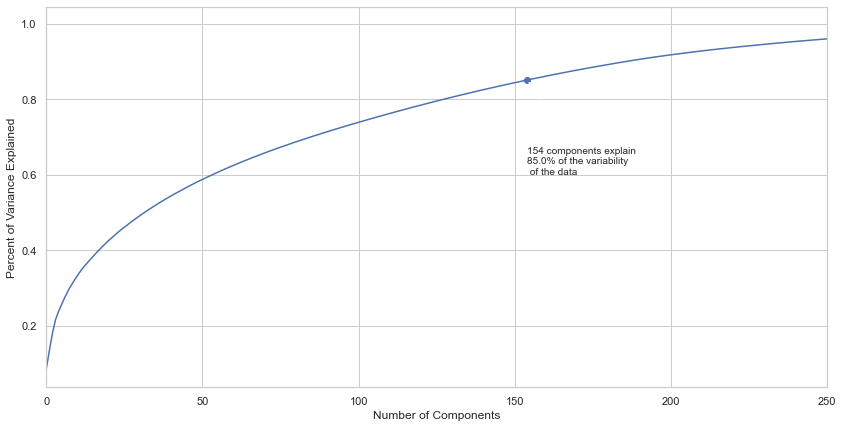

['MOBI_REGIO',
 'PLZ8_ANTG1',
 'KBA13_ANTG1',
 'LP_STATUS_FEIN',
 'KBA05_ANTG1',
 'LP_STATUS_GROB',
 'MOBI_RASTER',
 'KBA05_AUTOQUOT',
 'KBA05_GBZ',
 'KBA13_AUTOQUOTE',
 'ORTSGR_KLS9',
 'EWDICHTE',
 'PLZ8_BAUMAX',
 'PLZ8_ANTG4',
 'HH_EINKOMMEN_SCORE',
 'KBA13_BAUMAX',
 'KBA13_ANTG4',
 'CAMEO_DEUG_2015',
 'KBA13_ANTG3',
 'PLZ8_ANTG3']

In [243]:
pca_results(1, plot_pca = True, return_columns = True)

#####  Component 1

154 principal components explain 85.0% of the data
Features: ['MOBI_REGIO', 'PLZ8_ANTG1', 'KBA13_ANTG1', 'LP_STATUS_FEIN', 'KBA05_ANTG1', 'LP_STATUS_GROB', 'MOBI_RASTER', 'KBA05_AUTOQUOT', 'KBA05_GBZ', 'KBA13_AUTOQUOTE', 'ORTSGR_KLS9', 'EWDICHTE', 'PLZ8_BAUMAX', 'PLZ8_ANTG4', 'HH_EINKOMMEN_SCORE', 'KBA13_BAUMAX', 'KBA13_ANTG4', 'CAMEO_DEUG_2015', 'KBA13_ANTG3', 'PLZ8_ANTG3']


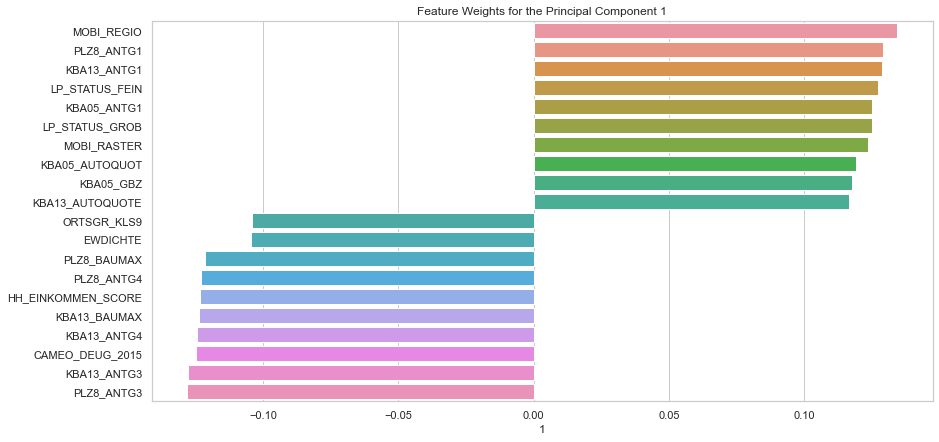

In [244]:
pca_results(1)


- The following features have the largest positive associations
    - `MOBI_REGIO` - movement patterns
    - `PLZ8_ANTG1` - number of 1-2 family houses in the PLZ8 region
    - `KBA13_ANTG1` - share of cars per 1-2 family houses
    - `LP_STATUS_FEIN` - social status (fine scale)
    - `KBA05_ANTG1` - Number of 1-2 family houses in the microcell
    - `LP_STATUS_GROB` - Social status (rough scale)
    - `MOBI_RASTER` - mobility pattern
    - `KBA05_AUTOQUOT` - share of cars per household in microcell
    
    
- The first principal component in positively associated with social status and movement patterns in small households of 1-2 family (single parents/couples without children)



- The following features have the largest negative associations
    - `PLZ8_ANTG3` - Number of 6-10 family houses in the PLZ8 region 
    - `KBA13_ANTG3` - car ownership per 6-10 family houses
    - `CAMEO_DEUG_2015` - wealth/life stage (rough scale)
    - `KBA13_ANTG4` - car ownership for 10+ family houses
    - `KBA13_BAUMAX` - Share of cars within most common building types within the PLZ8 
    - `HH_EINKOMMEN_SCORE` - Household net income
    


- The first principal component is most negatively associated when it comes to bigger households of at least 6 people


#####  Component 2

154 principal components explain 85.0% of the data
Features: ['ONLINE_AFFINITAET', 'FINANZ_SPARER', 'D19_GESAMT_ANZ_24', 'CJT_TYP_1', 'CJT_TYP_2', 'D19_GESAMT_ANZ_12', 'FINANZ_ANLEGER', 'ALTERSKATEGORIE_FEIN', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_ANZ_12', 'VK_DHT4A', 'CJT_TYP_3', 'D19_VERSAND_DATUM', 'D19_GESAMT_DATUM', 'CJT_TYP_6', 'D19_VERSAND_ONLINE_DATUM', 'CJT_TYP_5', 'CJT_TYP_4', 'D19_GESAMT_ONLINE_DATUM', 'FINANZ_VORSORGER']


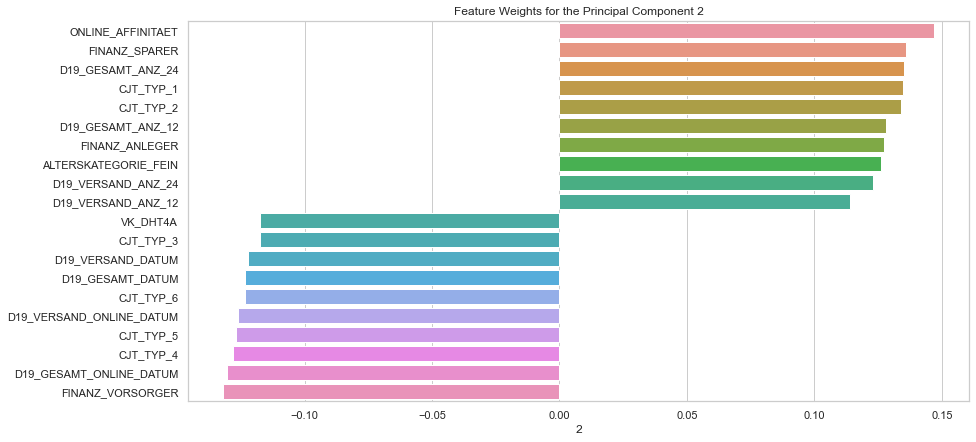

In [245]:
pca_results(2)

- The following features have the largest positve associations in the second principal component
    - `ONLINE_AFFINITAET` - online affinity
    - `FINANZ_SPARER` - financial topology: money saver
    - `D19_GESAMT_ANZ_24` - transaction activity TOTAL POOL in the last 12 to 24 months
    - `CJT_TYP_1` - Customer-Journey-Typology (Advertising- and Consumptionminimalist)?
    - `CJT_TYP_2` - Customer-Journey-Typology (Advertising- and Consumptiontraditionalist )?
    - `D19_GESAMT_ANZ_12` - transaction activity TOTAL POOL within the last 12 months 
    - `FINANZ_ANLEGER` - financial topology: investment
    - `ALTERSKATEGORIE_FEIN` - Estimated age based on given name analysis (fine scale)
    - `D19_VERSAND_ANZ_12` - transaction activity MAIL-ORDER in the last 12 months
    
    
- The second principal component is positively associated with financial activities, online affinity, and estimated age


- The following features have the largest negative assocaitions in the second principal component 
    - `D19_GESAMT_ONLINE_DATUM` - actuality of the last transaction with the complete file ONLINE
    - `FINANZ_VORSORGER` - financial topology (be prepared)
    - `CJT_TYP_4` - Customer-Journey-Typology (advertisinginterested Online-shopper)?
    - `CJT_TYP_5` - Customer-Journey-Typology
    - `D19_VERSAND_ONLINE_DATUM` - actuality of the last transaction for the segment mail-order ONLINE
    - `D19_GESAMT_DATUM` - actuality of the last transaction with the complete file TOTAL
    
    
- The second principal component is most negatively associated with financial preparedness and online transaction activity date


#### Number of Clusters

In [8]:
imp = SimpleImputer(strategy = 'mean')
azdias_imp = imp.fit_transform(azdias)
azdias_imp = pd.DataFrame(azdias_imp, columns = azdias.keys(), index = azdias.index)
azdias_imp.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,WEALTH_INTL_2015_5,LIFE_STAGE_INTL_2015_2,LIFE_STAGE_INTL_2015_3,LIFE_STAGE_INTL_2015_4,LIFE_STAGE_INTL_2015_5,DECADE_50.0,DECADE_60.0,DECADE_70.0,DECADE_80.0,DECADE_90.0
LNR,,,,,,,,,,,,,,,,,,,,,
910220,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
910225,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
910226,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
910241,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
910244,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [247]:
## determine the optimal number of clusters for the data

## standardize
sc = StandardScaler()
df_sc = sc.fit_transform(azdias_imp)


## PCA Reduction
pca = PCA(n_components= 154, random_state = rs)
df_pca = pca.fit_transform(df_sc)


In [248]:
## Find optimal number of clusters via scree plot
scores = []
for i in range(1, 26):
    
    print("fitting {} clusters".format(i))
    km_i = MiniBatchKMeans(n_clusters = i, random_state = rs)
    km_i.fit(df_pca)
    
    score = km_i.inertia_
    scores.append(score)

fitting 1 clusters
fitting 2 clusters
fitting 3 clusters
fitting 4 clusters
fitting 5 clusters
fitting 6 clusters
fitting 7 clusters
fitting 8 clusters
fitting 9 clusters
fitting 10 clusters
fitting 11 clusters
fitting 12 clusters
fitting 13 clusters
fitting 14 clusters
fitting 15 clusters
fitting 16 clusters
fitting 17 clusters
fitting 18 clusters
fitting 19 clusters
fitting 20 clusters
fitting 21 clusters
fitting 22 clusters
fitting 23 clusters
fitting 24 clusters
fitting 25 clusters


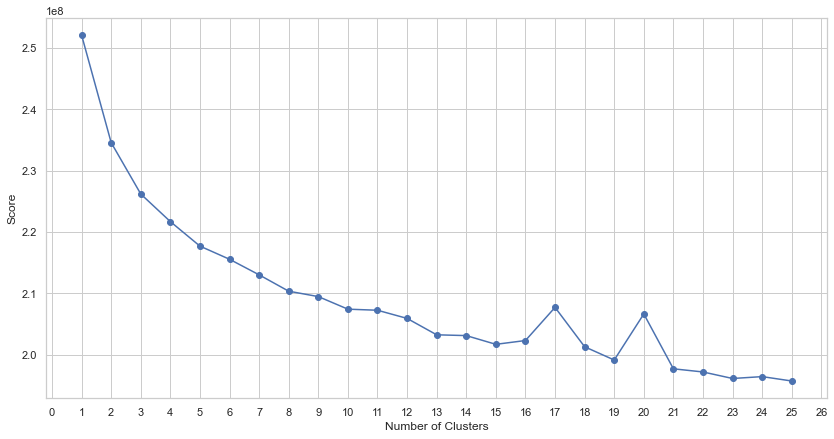

In [249]:
sns.set(style="whitegrid")
plt.figure(figsize= (14, 7))
plt.plot(range(1, 26), scores, marker = 'o')
plt.xticks(np.arange(0, 27, 1))
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.show()

- Using MiniBatchKmeans on the entire data gives an elbow at `k = 8`. Therefore, use 8 clusters for the analysis.

### Cluster Analysis

In [9]:
imp = SimpleImputer(strategy = 'mean')
azdias_imp = imp.fit_transform(azdias)
azdias_imp = pd.DataFrame(azdias_imp, columns = azdias.keys(), index = azdias.index)
azdias_imp.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,WEALTH_INTL_2015_5,LIFE_STAGE_INTL_2015_2,LIFE_STAGE_INTL_2015_3,LIFE_STAGE_INTL_2015_4,LIFE_STAGE_INTL_2015_5,DECADE_50.0,DECADE_60.0,DECADE_70.0,DECADE_80.0,DECADE_90.0
LNR,,,,,,,,,,,,,,,,,,,,,
910220,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
910225,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
910226,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
910241,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
910244,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [10]:
## standardize (start over)
sc = StandardScaler()
azdias_sc = sc.fit_transform(azdias_imp)

## PCA Reduction
pca = PCA(n_components= 154, random_state = rs)
azdias_pca = pca.fit_transform(azdias_sc)

## K-Means Clustering
km = KMeans(n_clusters = 8, random_state = rs)

azdias_labels = km.fit_predict(azdias_pca)

azdias_clust = azdias_imp.copy()
azdias_clust['CLUSTER'] = azdias_labels + 1
azdias_clust.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,LIFE_STAGE_INTL_2015_2,LIFE_STAGE_INTL_2015_3,LIFE_STAGE_INTL_2015_4,LIFE_STAGE_INTL_2015_5,DECADE_50.0,DECADE_60.0,DECADE_70.0,DECADE_80.0,DECADE_90.0,CLUSTER
LNR,,,,,,,,,,,,,,,,,,,,,
910220,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6
910225,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,6
910226,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7
910241,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5
910244,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,7


In [10]:
azdias_clusters = pd.DataFrame({'cluster_count': azdias_clust['CLUSTER'].value_counts()})
azdias_clusters['cluster_pct'] = azdias_clusters['cluster_count']/ azdias_clust.shape[0] * 100
azdias_clusters = azdias_clusters.reset_index().rename(columns = {'index': 'cluster'})
azdias_clusters

,cluster,cluster_count,cluster_pct
0,7,126736,16.017127
1,1,126364,15.970113
2,4,120558,15.236340
3,3,108198,13.674261
4,8,99295,12.549084
5,5,78882,9.969251
6,2,65714,8.305055
7,6,65506,8.278768


#### Customer Clusters

In [11]:
## Customers - imputation

customers_imp = imp.fit_transform(customers)
df_customers_imp = pd.DataFrame(customers_imp, columns = customers.keys(), index = customers.index)

df_customers_imp.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,WEALTH_INTL_2015_5,LIFE_STAGE_INTL_2015_2,LIFE_STAGE_INTL_2015_3,LIFE_STAGE_INTL_2015_4,LIFE_STAGE_INTL_2015_5,DECADE_50.0,DECADE_60.0,DECADE_70.0,DECADE_80.0,DECADE_90.0
LNR,,,,,,,,,,,,,,,,,,,,,
9626,1.0,10.0,10.000000,1.0,0.000000,0.0,2.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
143872,1.0,6.0,11.202558,1.0,0.000000,0.0,1.0,1.0,0.0,3.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
143873,1.0,8.0,8.000000,0.0,0.067456,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
143874,1.0,20.0,14.000000,7.0,0.000000,0.0,4.0,7.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
143888,1.0,11.0,10.000000,1.0,0.000000,0.0,2.0,1.0,0.0,3.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [12]:
## standardize
customers_sc = sc.fit_transform(df_customers_imp)

## PCA Reduction
customers_pca = pca.fit_transform(customers_sc)

customer_labels = km.fit_predict(customers_pca)


customer_clust = df_customers_imp.copy()
customer_clust['CLUSTER'] = customer_labels + 1
customer_clust.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,LIFE_STAGE_INTL_2015_2,LIFE_STAGE_INTL_2015_3,LIFE_STAGE_INTL_2015_4,LIFE_STAGE_INTL_2015_5,DECADE_50.0,DECADE_60.0,DECADE_70.0,DECADE_80.0,DECADE_90.0,CLUSTER
LNR,,,,,,,,,,,,,,,,,,,,,
9626,1.0,10.0,10.000000,1.0,0.000000,0.0,2.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8
143872,1.0,6.0,11.202558,1.0,0.000000,0.0,1.0,1.0,0.0,3.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1
143873,1.0,8.0,8.000000,0.0,0.067456,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6
143874,1.0,20.0,14.000000,7.0,0.000000,0.0,4.0,7.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2
143888,1.0,11.0,10.000000,1.0,0.000000,0.0,2.0,1.0,0.0,3.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,3


In [13]:
customer_clusters = pd.DataFrame({'cluster_count': customer_clust['CLUSTER'].value_counts()})
customer_clusters['cluster_pct'] =  customer_clusters['cluster_count']/customer_clust.shape[0] * 100
customer_clusters = customer_clusters.reset_index().rename(columns = {'index': 'cluster'})
customer_clusters


,cluster,cluster_count,cluster_pct
0,8,27794,19.730668
1,6,21383,15.179567
2,4,20034,14.221926
3,1,18825,13.363669
4,7,15897,11.285113
5,3,14505,10.296947
6,2,11415,8.103388
7,5,11014,7.818723


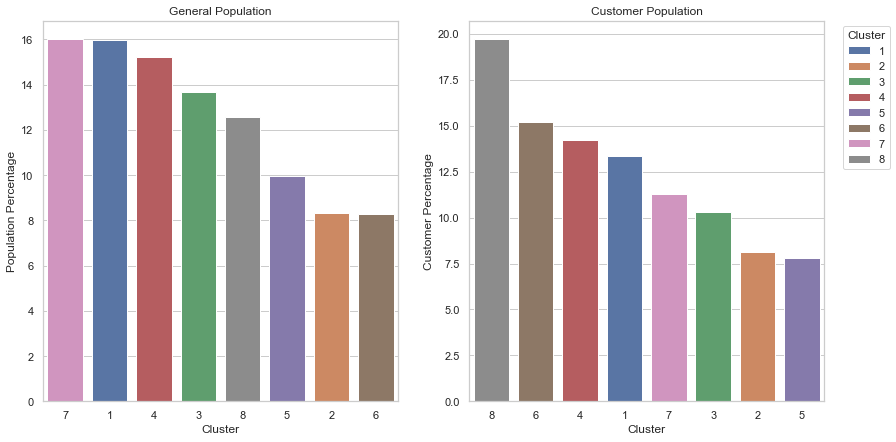

In [14]:
sns.set(style="whitegrid")
plt.figure(figsize = (14, 7))

plt.subplot(1, 2, 1)
plt.title('General Population')
ax1 = sns.barplot(data = azdias_clusters, x = 'cluster', y = 'cluster_pct', hue = 'cluster', order = azdias_clusters['cluster'], dodge = False)
ax1.set_ylabel('Population Percentage')
ax1.set_xlabel('Cluster')
ax1.get_legend().remove()

plt.subplot(1, 2, 2)
plt.title('Customer Population')
ax2 = sns.barplot(data = customer_clusters, x = 'cluster', y = 'cluster_pct', hue = 'cluster', order = customer_clusters['cluster'],  dodge = False)
ax2.set_ylabel('Customer Percentage')
ax2.set_xlabel('Cluster')
plt.legend(loc = 'upper right', bbox_to_anchor=(1.2, 1), title = 'Cluster')

plt.show()

- According to the plots above, cluster 1 is the most represented among the German population while cluster 8 is the most represented among the customer population.
- In the population group, the least represented group is cluster 6 while for the customers, the least represented is cluster 5.
    - Cluster 10 is one of the most represented groups in the population even though it is one of the least represented in the customers

### Cluster Interpretations

- **Target audience**: customer proportion is greater than the population
- **Non-target audience**: customer proportion is less than the population

In [15]:
clust_diff = azdias_clusters.merge(customer_clusters, on = 'cluster', suffixes = ('_pop','_cust'))
## if diff > 0, then target audience
clust_diff['pct_diff'] = clust_diff['cluster_pct_cust'] - clust_diff['cluster_pct_pop']
clust_diff.sort_values(by = 'pct_diff', ascending = False, inplace = True)
clust_diff

,cluster,cluster_count_pop,cluster_pct_pop,cluster_count_cust,cluster_pct_cust,pct_diff
4,8,99295,12.549084,27794,19.730668,7.181584
7,6,65506,8.278768,21383,15.179567,6.900799
6,2,65714,8.305055,11415,8.103388,-0.201667
2,4,120558,15.236340,20034,14.221926,-1.014415
5,5,78882,9.969251,11014,7.818723,-2.150529
1,1,126364,15.970113,18825,13.363669,-2.606444
3,3,108198,13.674261,14505,10.296947,-3.377314
0,7,126736,16.017127,15897,11.285113,-4.732014


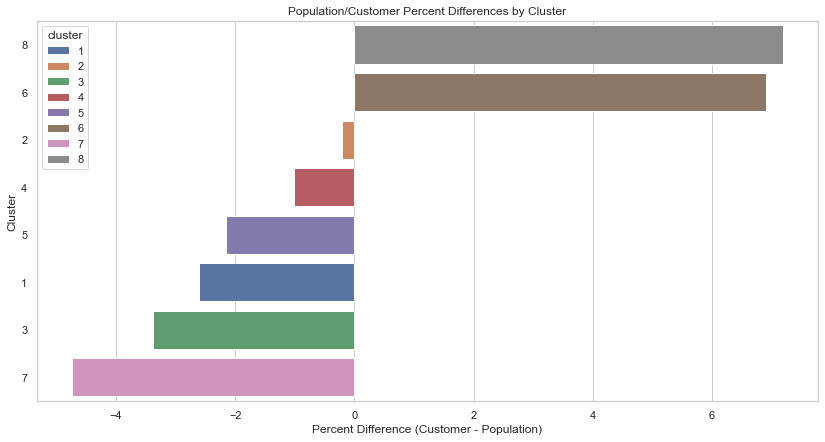

In [16]:
plt.figure(figsize = (14, 7))
sns.barplot(data = clust_diff, x = 'pct_diff', y = 'cluster', hue = 'cluster', orient = 'h', dodge = False, order = clust_diff['cluster'])
plt.xlabel('Percent Difference (Customer - Population)')
plt.ylabel('Cluster')
plt.title('Population/Customer Percent Differences by Cluster')
plt.show()


- Customer clusters 6 and 8 have a higher proportion than their population counterparts, meaning that the people in these groups are the target audiences.
    - The cluster with the largest positive margin is cluster 6


- Customer clusters 10 and 3 have a smaller proportion than their population counterparts, meaning that the people in these groups are outside the target audience
    - The cluster with the largest negative margin is cluster 10


#### Interpret Centroids

In [18]:
centroids = sc.inverse_transform(pca.inverse_transform(km.cluster_centers_))
df_centroids = pd.DataFrame(centroids, columns = df_customers_imp.keys())
df_centroids.set_index(np.arange(1,9), inplace = True)
df_centroids

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,WEALTH_INTL_2015_5,LIFE_STAGE_INTL_2015_2,LIFE_STAGE_INTL_2015_3,LIFE_STAGE_INTL_2015_4,LIFE_STAGE_INTL_2015_5,DECADE_50.0,DECADE_60.0,DECADE_70.0,DECADE_80.0,DECADE_90.0
1,2.021629,8.713611,10.184165,12.246673,0.082956,-0.003300,1.515463,11.567888,0.008122,3.448970,...,0.436254,0.031162,0.113229,0.215055,0.274970,0.381329,0.243911,0.121842,0.033304,0.001391
2,2.427546,14.951346,16.185349,3.352296,0.021571,0.617034,2.382496,3.040808,0.009295,2.782836,...,0.089255,0.118672,0.221006,0.352121,0.127591,0.024401,0.030494,0.165059,0.437529,0.390923
3,1.681146,9.810087,10.247355,3.421866,0.111116,0.075066,2.125834,3.238979,0.051858,2.975482,...,0.034306,0.019624,0.117694,0.463103,0.336394,0.375508,0.205517,0.138824,0.045715,0.008461
4,1.409869,14.945133,11.486793,1.721410,0.033530,0.184968,3.419652,1.587699,0.029181,2.819777,...,0.048771,0.097847,0.170314,0.439857,0.211807,0.253984,0.313995,0.282955,0.065972,0.002082
5,2.404394,10.664957,11.726016,21.624949,0.392530,0.084530,1.664529,20.492048,0.026094,3.398479,...,0.396028,0.019242,0.064624,0.210386,0.157599,0.246829,0.185602,0.217548,0.127062,0.075411
6,1.644892,9.281087,10.385953,1.813176,0.010824,0.038790,1.771424,1.790503,0.008994,2.172244,...,0.031052,0.186437,0.233377,0.349481,0.149145,0.343531,0.300598,0.141138,0.024246,0.003959
7,1.365729,15.677064,12.427988,1.453284,0.009484,0.310821,3.397340,1.361612,0.009227,2.198010,...,0.019124,0.241386,0.254588,0.317062,0.117262,0.165349,0.273760,0.354648,0.153106,0.017114
8,1.540706,9.303570,9.860672,1.653564,0.025366,0.024048,1.973262,1.626833,0.023179,2.981302,...,0.053846,0.060321,0.181142,0.425584,0.258791,0.435740,0.227817,0.082479,0.017174,0.002327


In [171]:
miss_age_cat = list(customers[customers['ALTERSKATEGORIE_FEIN'].isnull()].index)
miss_age_cat[:5]

[143872, 5545, 125562, 125583, 123506]

In [172]:
## clusters to interpret
interp_clusters = [6, 8, 3, 7]

## drop missing age categories ('ALTERSKATEGORIE_FEIN') from original customers data
customers_age_cat = customers.drop(index = miss_age_cat)

## list the customers with age categories 
customer_list = customers_age_cat.index

## filter the clustered customer set to thoese customers
customer_clust2 = customer_clust.loc[customer_list, :]

## narrow down to listed clusters
target_clusters = customer_clust2[customer_clust2['CLUSTER'].isin(interp_clusters)]

## group and find proportions to each age category by cluster
clust_tot = customers_target.groupby(['CLUSTER']).size()
age_tot = customers_target.groupby(['CLUSTER', 'ALTERSKATEGORIE_FEIN']).size()
age_prop = pd.DataFrame(age_tot/clust_tot, columns = ['age_prop']).reset_index()
age_prop.head()

,CLUSTER,ALTERSKATEGORIE_FEIN,age_prop
0,3,2.0,0.000138
1,3,3.0,0.000138
2,3,4.0,0.000758
3,3,5.0,0.004205
4,3,6.0,0.025991


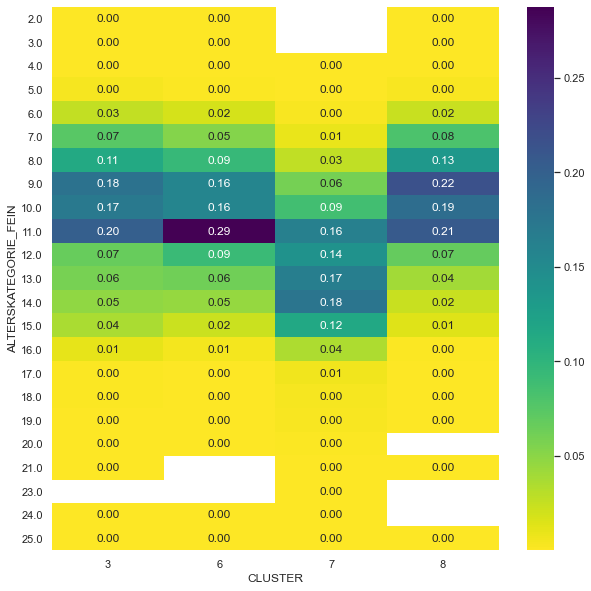

In [173]:
age_pivot = pd.pivot(age_prop, columns = 'CLUSTER', index = 'ALTERSKATEGORIE_FEIN', values = 'age_prop')
plt.figure(figsize = (10, 10))
sns.heatmap(age_pivot, cmap = 'viridis_r', annot = True, fmt = '.2f')
plt.yticks(rotation = 0)
plt.show()


In [20]:
def cluster_info(clusters, components = (1, 2), num_features = 10, top = True):
    """
    This function gets the top 10 features by principal component and returns the centroid values for those features according to the given cluster labels.
    INPUT: list of clusters to show, list of principal component numbers (must be 2 in a tuple)
    OUTPUT: two heatmaps showing the centroid values for the PCA features
    """
    ## set the cluster as a variable before metling
    df_centroids_reset = df_centroids.reset_index().rename(columns = {'index': 'cluster'})
    ## set cluster as ID variable and melt 
    df_centroids_melt = df_centroids_reset.melt(id_vars = ['cluster'], var_name = 'feature')
    
    ## PCA for first values
    

    
    ## PCA for second value
    if top:
        pca1_features = pca_results(components[0], return_columns = True)[:num_features]
        pca2_features = pca_results(components[1], return_columns = True)[:num_features]
    else:
        pca1_features = pca_results(components[0], return_columns = True)[-num_features:]
        pca2_features = pca_results(components[1], return_columns = True)[-num_features:]
        
        
    pca1_centroids = df_centroids_melt[(df_centroids_melt['feature'].isin(pca1_features)) &
                                  ((df_centroids_melt['cluster'].isin(clusters)))]
    
    pca1_pivot = pca1_centroids.pivot(columns = 'cluster', index = 'feature', values = 'value')
    
    
    pca2_centroids = df_centroids_melt[(df_centroids_melt['feature'].isin(pca2_features)) &
                                  ((df_centroids_melt['cluster'].isin(clusters)))]
    
    pca2_pivot = pca2_centroids.pivot(columns = 'cluster', index = 'feature', values = 'value')

    
    plt.figure(figsize = (30, 14))
    plt.suptitle('Feature Centroids', fontsize = 22)
    plt.subplot(1, 2, 1)
    plt.title('Principal Component {}'.format(components[0]), fontsize = 20)
    ax1 = sns.heatmap(pca1_pivot, annot = True, fmt = '.1f', cmap = 'viridis_r', cbar = False,
                     annot_kws={'size':18})
    ax1.set_ylabel('Feature', fontsize = 19)
    ax1.set_xlabel('Cluster', fontsize = 19)
    plt.xticks(fontsize = 22)
    
    
    
    plt.subplot(1, 2, 2)
    plt.title('Principal Component {}'.format(components[1]), fontsize = 22)
    ax2 = sns.heatmap(pca2_pivot, annot = True, fmt = '.1f', cmap = 'viridis_r', cbar = False, annot_kws={'size':18})
    ax2.set_ylabel(' ')
    ax2.set_xlabel('Cluster', fontsize = 19)
    plt.xticks(fontsize = 22)
    
    plt.show()

##### Target Customers

In [21]:
## features are ordered according to PC weight in descending order
target_clusters = [6, 8]
pc1_features = pca_results(1, return_columns = True)[:10]
df_centroids.loc[target_clusters, pc1_features]

,MOBI_REGIO,PLZ8_ANTG1,KBA13_ANTG1,LP_STATUS_FEIN,KBA05_ANTG1,LP_STATUS_GROB,MOBI_RASTER,KBA05_AUTOQUOT,KBA05_GBZ,KBA13_AUTOQUOTE
6,4.209908,3.027106,2.887353,8.199547,2.677425,3.860150,3.669492,3.969376,4.126259,3.756995
8,4.096779,2.720359,2.562617,8.819293,2.814170,4.340325,3.159345,3.728721,3.983667,2.897862


In [22]:
pc2_features = pca_results(2, return_columns = True)[:10]
df_centroids.loc[target_clusters, pc2_features]

,ONLINE_AFFINITAET,FINANZ_SPARER,D19_GESAMT_ANZ_24,CJT_TYP_1,CJT_TYP_2,D19_GESAMT_ANZ_12,FINANZ_ANLEGER,ALTERSKATEGORIE_FEIN,D19_VERSAND_ANZ_24,D19_VERSAND_ANZ_12
6,2.239691,1.162242,0.804395,1.718818,1.416994,0.386980,1.627827,10.385953,0.570478,0.255894
8,2.491410,1.066851,0.993594,1.491112,1.425512,0.505643,1.085770,9.860672,0.760454,0.374573


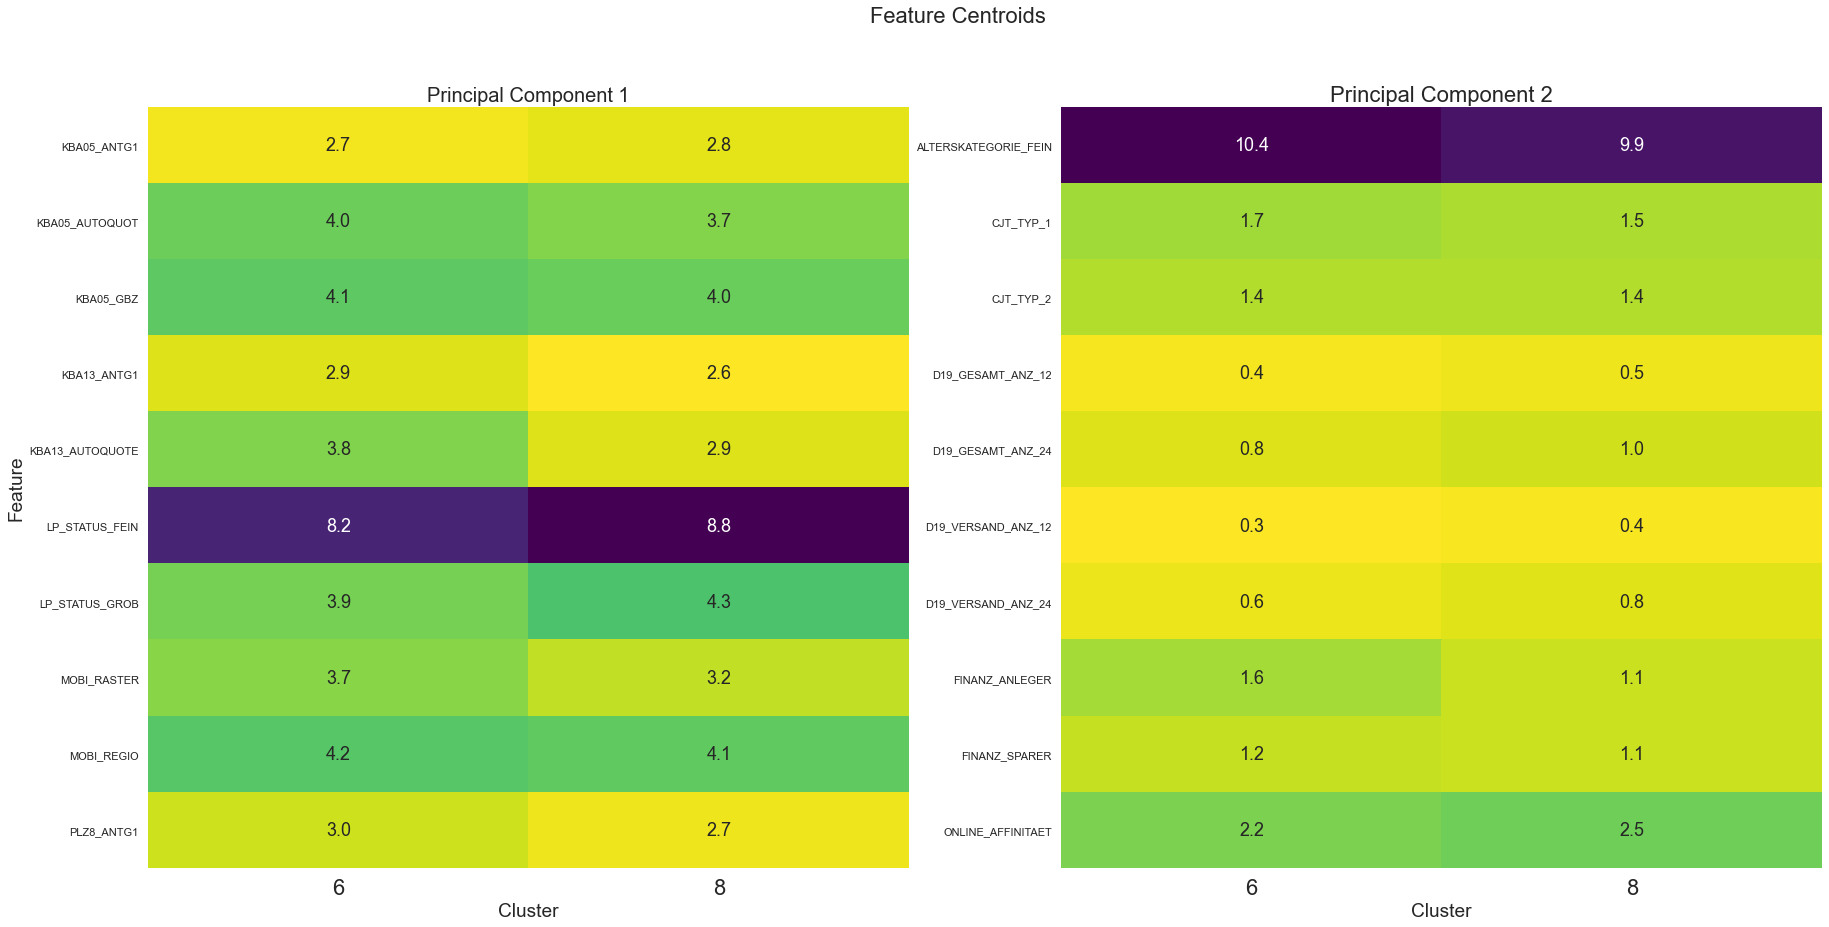

In [23]:
cluster_info(target_clusters)

#### Cluster 6


**Component 1**

- `KBA05_ANTG1` = 3 -> high share of 1-2 family homes in the cell
- `KBA05_AUTOQUOT` = 4 -> high car quote share per household
- `KBA05_GBZ` = 4 -> 17-22 buildings in microcell
- `KBA13_ANTG1` = 3 -> average share of car ownership per 1-2 family houses
- `LP_STATUS_FEIN` = 8 -> new houseowners
- `LP_STATUS_GROB` = 4 -> average earners
- `MOBI_REGIO` = 4 -> low movement patterns
- `PLZ8_ANTG1` = 3 -> high share of 1-2 family home in PLZ8 

**Component 2**

- `ALTERSKATEGORIE_FEIN` = 10 -> age group born in the early 1940s
- `D19_GESAMT_ANZ_12` = 0 -> no known financial transaction activity (total)
- `D19_GESAMT_ANZ_24` = 1 -> very low transaction activity over the past 2 years (total)
- `D19_VERSAND_ANZ_12` =0 -> no activity in transaction mail-order over the past year
- `D19_VERSAND_ANZ_24` = 1 -> very low activity in transaction mail-order over the past 2 years
- `FINANZ_ANLEGER` = 2 -> high financial investment
- `FINANZ_SPARER` = 1 -> very high money saving
- `ONLINE_AFFINITAET` = 2 -> middle-level online affinity

#### Cluster 8

**Component 1**

- `KBA05_ANTG1` = 3 -> high share of 1-2 family homes in the cell
- `KBA05_AUTOQUOT` = 4 -> high car quote share per household
- `KBA05_GBZ` = 4 -> 17-22 buildings in microcell
- `KBA13_ANTG1` = 3 -> average share of car ownership per 1-2 family houses
- `LP_STATUS_FEIN` = 9 -> houseowners
- `LP_STATUS_GROB` = 4 -> average earners
- `MOBI_REGIO` = 4 -> low movement patterns
- `PLZ8_ANTG1` = 3 -> high share of 1-2 family home in PLZ8 


**Component 2**

- `ALTERSKATEGORIE_FEIN` = 10 -> age group born in early 1940s
- `D19_GESAMT_ANZ_12` = 1 -> very low financial transaction activity (total)
- `D19_GESAMT_ANZ_24` = 1 -> very low transaction activity over the past 2 years (total)
- `D19_VERSAND_ANZ_12` = 0 -> no activity in transaction mail-order over the past year
- `D19_VERSAND_ANZ_24` = 1 -> very low activity in transaction mail-order over the past 2 years
- `FINANZ_ANLEGER` = 1 -> very high financial investment
- `FINANZ_SPARER` = 1 -> very high money saving
- `ONLINE_AFFINITAET` = 2.5 -> middle-high-level online affinity

#### Target Customer Description

- This target customer groups represent elderly houseowners born in the late 1940s. They live in single or double family homes in large communities and have small mobility in society. These people tend to have very high retirement funds due to large scales in money saving and investments. While they have a moderate online affinity, they have little to no transaction activity in mail orders over the past 2 years.


##### Non-Target Customers

In [61]:
non_target_clusters = [7, 3]
df_centroids.loc[non_target_clusters, pc1_features]

,MOBI_REGIO,PLZ8_ANTG1,KBA13_ANTG1,LP_STATUS_FEIN,KBA05_ANTG1,LP_STATUS_GROB,MOBI_RASTER,KBA05_AUTOQUOT,KBA05_GBZ,KBA13_AUTOQUOTE
7,4.409298,3.104162,2.969233,8.551575,2.789500,3.992224,4.035546,4.212547,4.256813,3.919037
3,3.676487,2.575941,2.431767,7.627522,2.330188,3.830756,2.788354,3.558211,3.739946,2.699737


In [62]:
df_centroids.loc[non_target_clusters, pc2_features]

,ONLINE_AFFINITAET,FINANZ_SPARER,D19_GESAMT_ANZ_24,CJT_TYP_1,CJT_TYP_2,D19_GESAMT_ANZ_12,FINANZ_ANLEGER,ALTERSKATEGORIE_FEIN,D19_VERSAND_ANZ_24,D19_VERSAND_ANZ_12
7,4.048234,1.537440,3.550346,2.182966,1.796448,2.515571,2.198952,12.427988,3.084443,2.132021
3,2.943053,1.189885,1.672596,1.692404,1.697634,1.041888,1.082199,10.247355,1.382769,0.847751


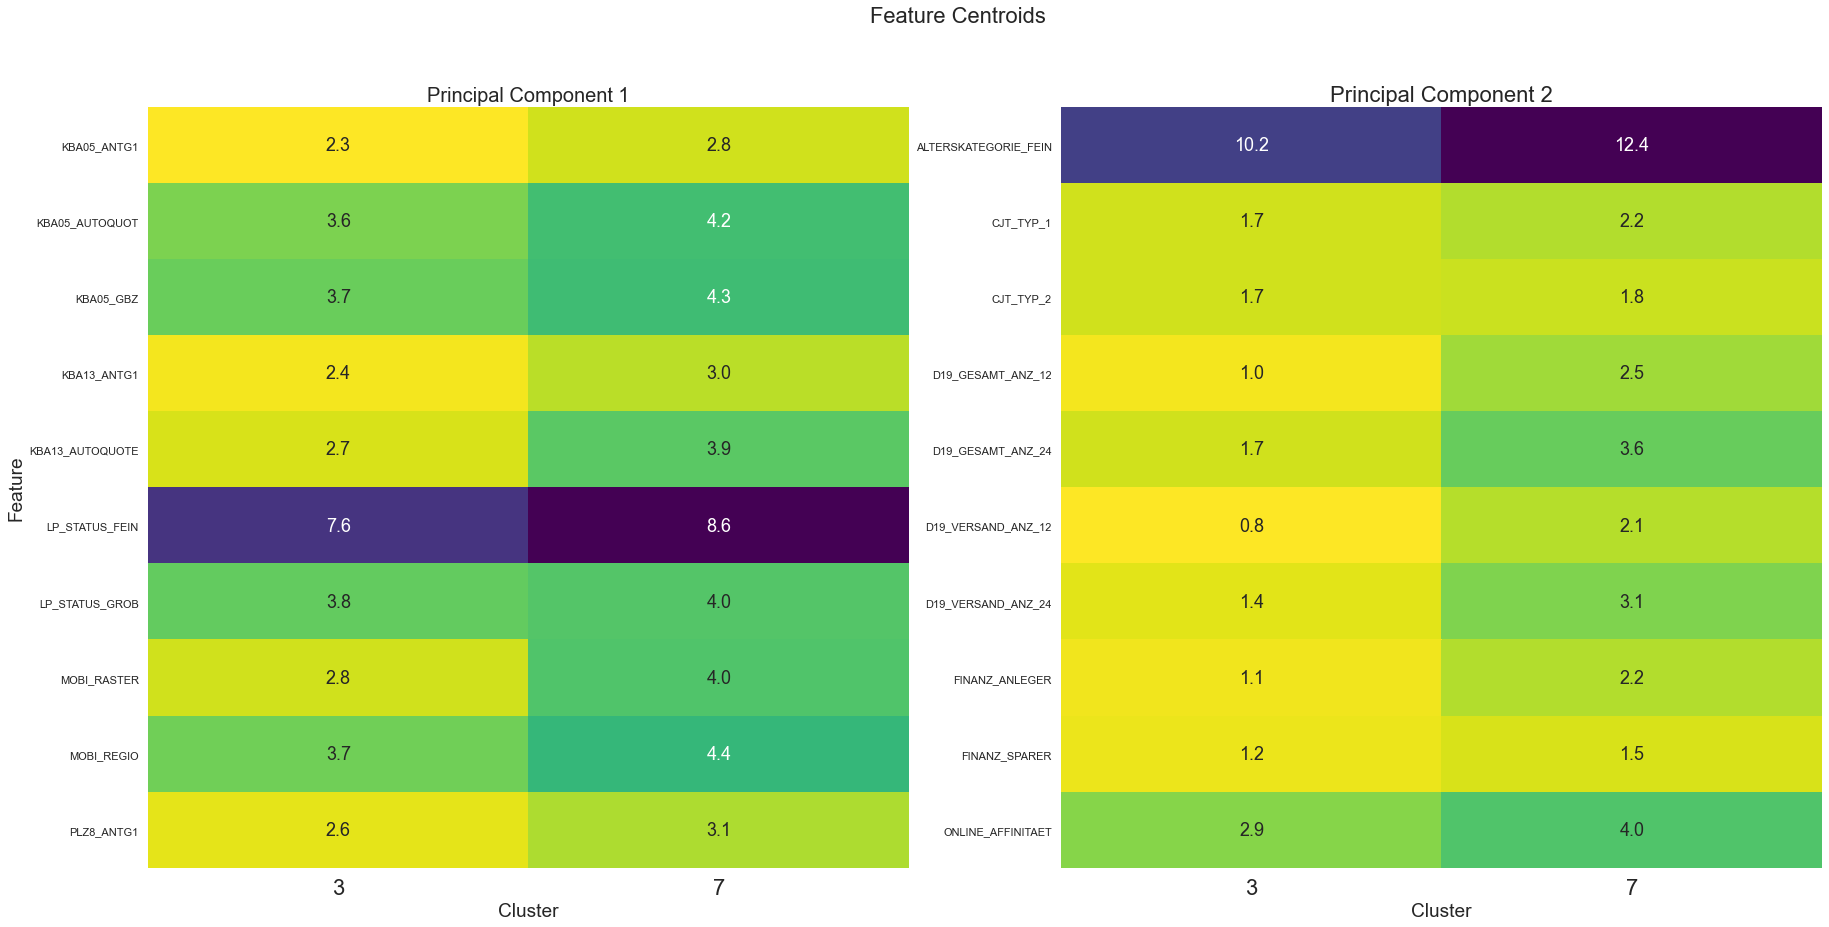

In [63]:
cluster_info(non_target_clusters)

#### Cluster 3

**Component 1**

- `KBA05_ANTG1` = 2 -> average share of 1-2 family homes in the cell
- `KBA05_AUTOQUOT` = 4 -> high car quote share per household
- `KBA05_GBZ` = 4 -> 17-22 buildings in microcell
- `KBA13_ANTG1` = 2 -> low share of car ownership per 1-2 family houses
- `LP_STATUS_FEIN` = 8 -> new houseowners
- `LP_STATUS_GROB` = 4 -> average earners
- `MOBI_REGIO` = 4 -> low movement patterns
- `PLZ8_ANTG1` = 3 -> high share of 1-2 family home in PLZ8 


**Component 2**

- `ALTERSKATEGORIE_FEIN` = 10 -> age group born in early 1940s
- `D19_GESAMT_ANZ_12` = 1 -> very low financial transaction activity (total)
- `D19_GESAMT_ANZ_24` = 2 -> low transaction activity over the past 2 years (total)
- `D19_VERSAND_ANZ_12` = 1 -> very low activity in transaction mail-order over the past year
- `D19_VERSAND_ANZ_24` = 1 -> very low transaction mail-order over the past 2 years
- `FINANZ_ANLEGER` = 1 -> very high financial investment
- `FINANZ_SPARER` = 1 -> very high money saving
- `ONLINE_AFFINITAET` = 3 -> high-level online affinity

#### Cluster 7

**Component 1**

- `KBA05_ANTG1` = 3 -> high share of 1-2 family homes in the cell
- `KBA05_AUTOQUOT` = 4 -> high car quote share per household
- `KBA05_GBZ` = 4 -> 17-22 buildings in microcell
- `KBA13_ANTG1` = 3 -> average share of car ownership per 1-2 family houses
- `LP_STATUS_FEIN` = 9 -> houseowners
- `LP_STATUS_GROB` = 4 -> average earners
- `MOBI_REGIO` = 4 -> low movement patterns
- `PLZ8_ANTG1` = 3 -> high share of 1-2 family home in PLZ8 


**Component 2**

- `ALTERSKATEGORIE_FEIN` = 12 -> age group born in early 1950s
- `D19_GESAMT_ANZ_12` = 3 -> slightly increased transaction activity (total)
- `D19_GESAMT_ANZ_24` = 4 -> increased transaction activity over the past 2 years (total)
- `D19_VERSAND_ANZ_12` = 2 -> low activity in transaction mail-order over the past year
- `D19_VERSAND_ANZ_24` = 3 -> slightly increased transaction mail-order over the past 2 years
- `FINANZ_ANLEGER` = 2 -> high financial investment
- `FINANZ_SPARER` = 1.5 -> very high money saving
- `ONLINE_AFFINITAET` = 4 -> very high online affinity

#### Non-Target Customer Description

- The non-target groups represent younger houseowners born in the late 1940s to early 1950s. Like the target groups, these people live in single or double family homes in large communities and have small mobility in society. However, they tend to have high financial scales in money saving and investments. Also, they have a very high online affinity, as well as higher transaction activities in mail orders over the past 2 years.

## Part 3: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [11]:
from sklearn.model_selection import train_test_split

In [42]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [40]:
## clean the data according to the clean_data function
mailout_train = clean_data(mailout_train)

In [12]:

mailout_train = pd.read_csv('Udacity_MAILOUT_TRAIN_CLEANED.csv', index_col = 'LNR')
mailout_train.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,WEALTH_INTL_2015_5,LIFE_STAGE_INTL_2015_2,LIFE_STAGE_INTL_2015_3,LIFE_STAGE_INTL_2015_4,LIFE_STAGE_INTL_2015_5,DECADE_50.0,DECADE_60.0,DECADE_70.0,DECADE_80.0,DECADE_90.0
LNR,,,,,,,,,,,,,,,,,,,,,
1763,1.0,8.0,8.0,15.0,0.0,0.0,1.0,13.0,0.0,3.0,...,0,0,0,1,0,0,0,0,0,0
1771,4.0,13.0,13.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0,...,0,1,0,0,0,0,0,1,0,0
1776,1.0,9.0,7.0,0.0,NaN,0.0,0.0,1.0,0.0,4.0,...,0,0,0,1,0,0,0,0,0,0
1460,1.0,6.0,6.0,4.0,0.0,0.0,2.0,4.0,0.0,4.0,...,0,0,0,1,0,0,0,0,0,0
1783,1.0,9.0,9.0,53.0,0.0,0.0,1.0,44.0,0.0,3.0,...,0,0,0,0,0,1,0,0,0,0


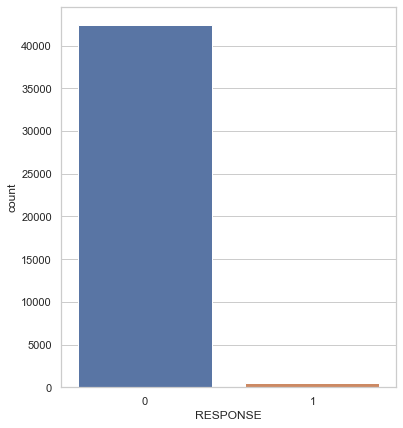

In [188]:
plt.figure(figsize = (6 , 7))
sns.countplot(data = mailout_train, x = 'RESPONSE');

In [181]:
print('{}% of customers responded to the campaign'.format(round(mailout_train['RESPONSE'].mean()* 100, 2)))

1.24% of customers responded to the campaign


In [189]:
## Customer IDs in the training data who are in the CUSTOMERS data
num_custs = len(set(mailout_train.index) - set(customers.index))
print('{} customers in the training set are in the customers set'.format(num_custs))

11699 customers in the training set are in the customers set


#### Train/Test Split

In [13]:
mailout_X = mailout_train.drop(columns = 'RESPONSE')
mailout_Y = mailout_train['RESPONSE']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(mailout_X, mailout_Y, test_size = 0.2, random_state = rs)


# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 34369 samples.
Testing set has 8593 samples.


In [15]:
## define function to transform the predictors
def transform_X(X):
    """
    INPUT: Training set of predictors in the original scale without imputations
    OUTPUT: Training set transformed to the PCA scale according to last section's parameters
    """
    
    ## Impute
    X_imp = imp.fit_transform(X)

    ## standardize
    X_sc = sc.fit_transform(X_imp)

    ## PCA Reduction
    X_pca = pca.fit_transform(X_sc)
    
    return X_pca

#### Scaling Split Training Set

In [16]:
## training set
Xtrain_pca = transform_X(X_train)
Xtrain_pca.shape

(34369, 154)

#### Scaling Split Test Set

In [17]:
## testing set
Xtest_pca = transform_X(X_test)
Xtest_pca.shape

(8593, 154)

### Prediction algorithms
- logistic regression
- bagging
- adaBoost
- gradient descent boosting

- Select algorithm that fits best with training data

In [61]:
from time import time
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, make_scorer

#### Logistic Regression

In [62]:
def prediction_tests(mod, train_x = Xtrain_pca, test_x = Xtest_pca, train_y = y_train, test_y = y_test):
    
    ## fit model
    start = time()
    mod.fit(train_x, train_y)
    end = time()
    
    ## predict by training
    pred_train = mod.predict(train_x)

    ## predict by testing set
    pred_test = mod.predict(test_x)

    
    ## timing
    timing = end - start
    print('Timing: {} s'.format(timing))
    
    accuracy_train = accuracy_score(train_y, pred_train)
    roc_train = roc_auc_score(train_y, pred_train)
    report_train = classification_report(train_y, pred_train, zero_division = 0)

    
    print('Training Accuracy: {}, Training ROC: {}'.format(accuracy_train, roc_train))
    print(report_train)

    accuracy_test = accuracy_score(test_y, pred_test)
    roc_test = roc_auc_score(test_y, pred_test)
    report_test = classification_report(test_y, pred_test, zero_division = 0)
    print('Testing Accuracy: {}, Testing ROC: {}'.format(accuracy_test, roc_test))
    print(report_test)
    
    ## ROC Curves
    
    ## training
    probs_tr = mod.predict_proba(train_x)[:, 1]

    fpr_tr, tpr_tr, threshold_tr = roc_curve(train_y, probs_tr)
    auc_tr = auc(fpr_tr, tpr_tr)
    
    ## testing
    probs_t = mod.predict_proba(test_x)[:, 1]

    fpr_t, tpr_t, threshold_t = roc_curve(test_y, probs_t)
    auc_t = auc(fpr_t, tpr_t)
    
    plt.figure(figsize = (18, 7))
    plt.subplot(1, 2, 1)
    plt.plot(fpr_tr, tpr_tr, 'b', label = 'AUC Training: %0.2f' % auc_tr)
    plt.plot([0, 1], [0, 1],'r--')
    plt.legend()
    plt.title('Training Data ROC Curve')
        
    plt.subplot(1, 2, 2)
    plt.plot(fpr_t, tpr_t, 'b', label = 'AUC Testing: %0.2f' % auc_t)
    plt.plot([0, 1], [0, 1],'r--')
    plt.legend()
    plt.title('Testing Data ROC Curve')
    

    

#### Logistic Regression

Timing: 0.5542268753051758 s
Training Accuracy: 0.9875469172801071, Training ROC: 0.5
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     33941
           1       0.00      0.00      0.00       428

    accuracy                           0.99     34369
   macro avg       0.49      0.50      0.50     34369
weighted avg       0.98      0.99      0.98     34369

Testing Accuracy: 0.9878971255673222, Testing ROC: 0.5
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8489
           1       0.00      0.00      0.00       104

    accuracy                           0.99      8593
   macro avg       0.49      0.50      0.50      8593
weighted avg       0.98      0.99      0.98      8593



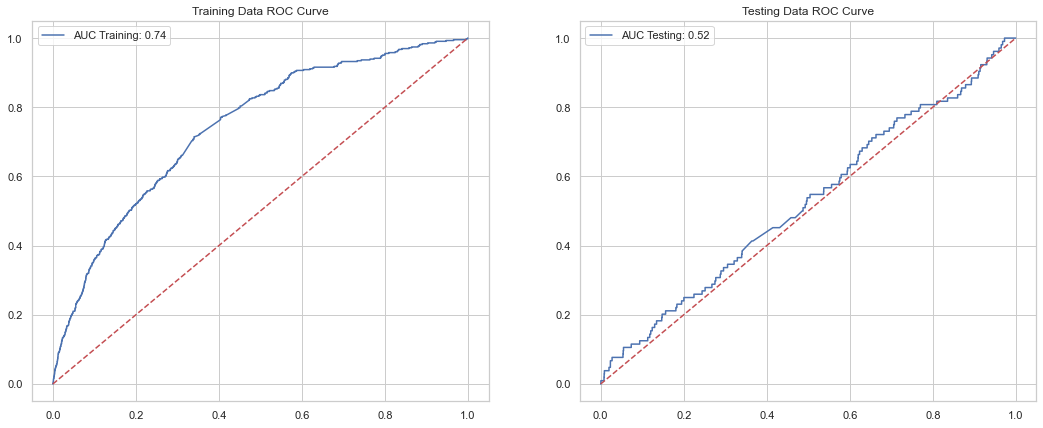

In [63]:
prediction_tests(LogisticRegression(random_state = rs))

#### AdaBoost

Timing: 27.7001531124115 s
Training Accuracy: 0.9875469172801071, Training ROC: 0.5011534928533213
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     33941
           1       0.50      0.00      0.00       428

    accuracy                           0.99     34369
   macro avg       0.74      0.50      0.50     34369
weighted avg       0.98      0.99      0.98     34369

Testing Accuracy: 0.9878971255673222, Testing ROC: 0.5
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8489
           1       0.00      0.00      0.00       104

    accuracy                           0.99      8593
   macro avg       0.49      0.50      0.50      8593
weighted avg       0.98      0.99      0.98      8593



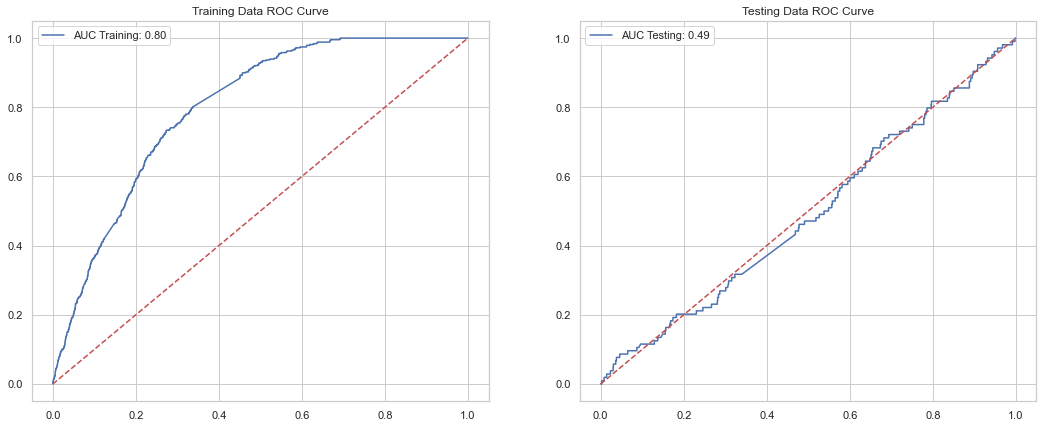

In [64]:
prediction_tests(AdaBoostClassifier(random_state = rs))

- Although not as long as a random forest, the training accuracy is similar to that of the random forest

#### Extreme Gradient Boosting

Timing: 11.068092107772827 s
Training Accuracy: 0.998457912653845, Training ROC: 0.9380841121495327
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     33941
           1       1.00      0.88      0.93       428

    accuracy                           1.00     34369
   macro avg       1.00      0.94      0.97     34369
weighted avg       1.00      1.00      1.00     34369

Testing Accuracy: 0.9878971255673222, Testing ROC: 0.5
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8489
           1       0.00      0.00      0.00       104

    accuracy                           0.99      8593
   macro avg       0.49      0.50      0.50      8593
weighted avg       0.98      0.99      0.98      8593



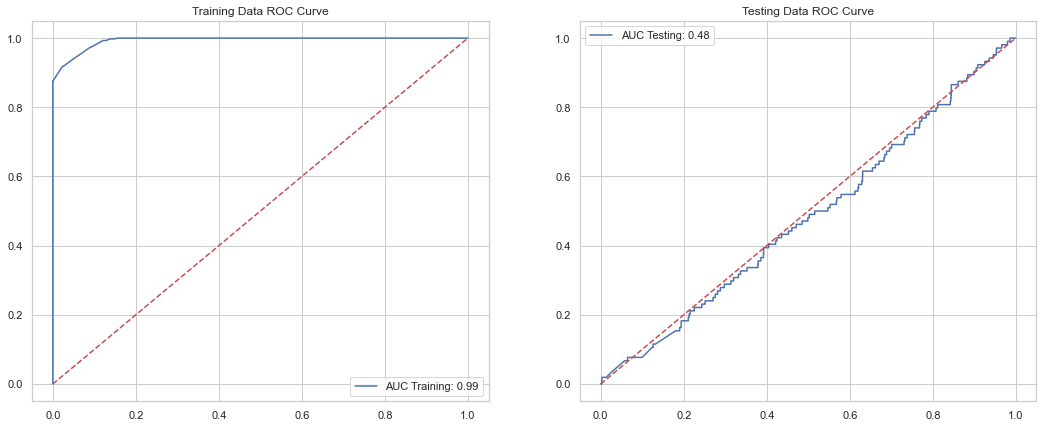

In [65]:

prediction_tests(xgb.XGBClassifier(random_state = rs))

- Takes too long to fit, but gives quite reasonable F-scores, particularly in the testing set. Also, the training ROC score is the highest so far

#### Bagging Classifier

Timing: 128.20721101760864 s
Training Accuracy: 0.9954319299368617, Training ROC: 0.816588785046729
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     33941
           1       1.00      0.63      0.78       428

    accuracy                           1.00     34369
   macro avg       1.00      0.82      0.89     34369
weighted avg       1.00      1.00      0.99     34369

Testing Accuracy: 0.9861515186779937, Testing ROC: 0.4991165037106844
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8489
           1       0.00      0.00      0.00       104

    accuracy                           0.99      8593
   macro avg       0.49      0.50      0.50      8593
weighted avg       0.98      0.99      0.98      8593



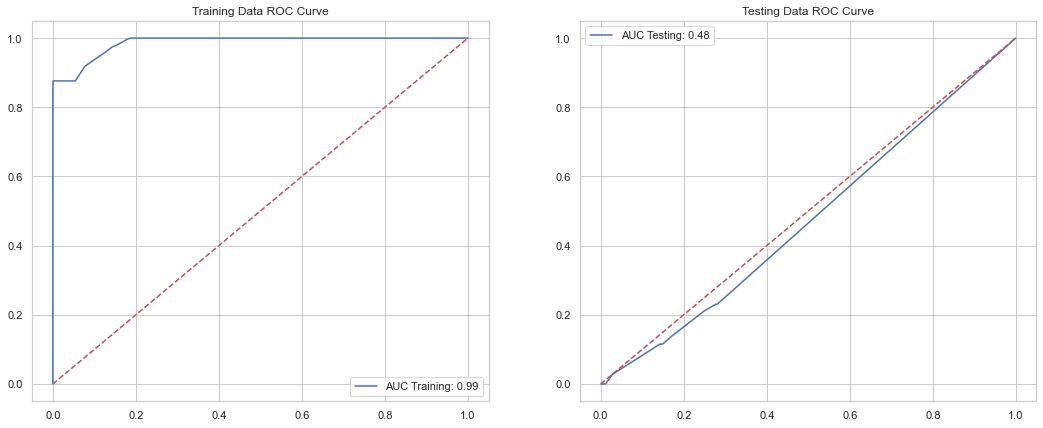

In [66]:
prediction_tests(BaggingClassifier(random_state = rs))

- The timing is slightly lower and the training ROC score is higher than that of the gradient boosting classifier. Therefore, use this classifier

- Based on the classification reports above, all of the four algorithms display a precision or recall scores of 0 for `RESPONSE` = 1 in contrast to scores near 1 for `RESPONSE` = 0 in the testing data.
    - For the training data, there is some presision or recall for `RESPONSE` = 1 for bagging and gradient boosting but little or none for adaboost and logistic regression.
- Since the data is extremely unbalanced, it is hard for any algorithm to distinguish between a positive or negative response from a customer.
- The testing data ROC scores of 0.5 suggest that they can perfectly predict `RESPONSE` = 0 but not `RESPONSE` = 1.



- The low number of support for both training and testing data sets suggests that an alternate method to train any algorithm is to make this data somewhat balanced through sampling methods.
- A good way to approach this is to think about this problem using an over-sampling technique such as SMOTE as described [here](https://towardsdatascience.com/how-to-effortlessly-handle-class-imbalance-with-python-and-smote-9b715ca8e5a7)

### Resampling
- Undersampling -> randomly resamples the imbalanced dataset and deletes samples from the majority class - `RESPONSE` = 0
- Oversampling -> randomly resamples the imbalanced dataset and duplicates samples from minority class - `RESPONSE` = 1
- Typically an oversmpling technique is better since undersampling means loss of valuable information for the majority class

In [21]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline

### Oversampling - ADASYN

In [105]:
## 1. Train/validation/test split
X_train, X_test, y_train, y_test = train_test_split(mailout_X, mailout_Y, test_size = 0.2, random_state = rs)
print(X_train.shape)

## validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = rs)

print(X_train.shape)

(34369, 377)
(30932, 377)


In [106]:
## ADASYN oversampling generated from real training set

adsyn_samp = ADASYN(random_state = rs)


In [107]:
samp_pipeline = Pipeline([
        ('imputation', imp),
        ('scaling', sc),
        ('PCA', pca),
        ('ADASYN', adsyn_samp)
    ])

Xtrain_res, ytrain_res = samp_pipeline.fit_resample(X_train, y_train)
Xtrain_res.shape

(61044, 154)

In [91]:
def validation_tests(mod, X = mailout_X, Y = mailout_Y):
    
    ## 1. Train/validation/test split
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = rs)

    ## validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = rs)

    pipeline = Pipeline([
        ('imputation', imp),
        ('scaling', sc),
        ('PCA', pca),
        ('ADASYN', adsyn_samp),
        ('model', mod)
    ])
    
    start = time()
    pipeline.fit(X_train, y_train)
    end = time()
    
    ## calculate timing
    timing = end - start
    print('Timing: {} s'.format(timing))
    
    ## validation
    pred_val = pipeline.predict(X_val)
        
    roc_val = roc_auc_score(y_val, pred_val)
    report_val = classification_report(y_val, pred_val)
    print('Validation ROC: {}'.format(roc_val))
    print(report_val)
    
    
    ## testing
    pred_test = pipeline.predict(X_test)
    
    roc_test = roc_auc_score(y_test, pred_test)
    report_test = classification_report(y_test, pred_test)
    print('Testing ROC: {}'.format(roc_test))
    print(report_test)


#### Logistic Regression

In [92]:
validation_tests(LogisticRegression(random_state = rs))


Timing: 2.348155975341797 s
Validation ROC: 0.5280666213634557
              precision    recall  f1-score   support

           0       0.99      0.62      0.76      3391
           1       0.02      0.43      0.03        46

    accuracy                           0.62      3437
   macro avg       0.50      0.53      0.40      3437
weighted avg       0.97      0.62      0.75      3437

Testing ROC: 0.5900945341029568
              precision    recall  f1-score   support

           0       0.99      0.63      0.77      8489
           1       0.02      0.55      0.03       104

    accuracy                           0.63      8593
   macro avg       0.50      0.59      0.40      8593
weighted avg       0.98      0.63      0.76      8593



#### AdaBoost

In [93]:
validation_tests(AdaBoostClassifier(random_state = rs))


Timing: 50.829055070877075 s
Validation ROC: 0.5362147885066608
              precision    recall  f1-score   support

           0       0.99      0.81      0.89      3391
           1       0.02      0.26      0.03        46

    accuracy                           0.80      3437
   macro avg       0.50      0.54      0.46      3437
weighted avg       0.97      0.80      0.88      3437

Testing ROC: 0.5391020732712922
              precision    recall  f1-score   support

           0       0.99      0.82      0.90      8489
           1       0.02      0.26      0.03       104

    accuracy                           0.81      8593
   macro avg       0.50      0.54      0.46      8593
weighted avg       0.98      0.81      0.89      8593



#### Extreme Gradient Boosting

In [94]:
xgb_clf = xgb.XGBClassifier(random_state = rs)
validation_tests(xgb_clf)

Timing: 20.018952131271362 s
Validation ROC: 0.47185965407151925
              precision    recall  f1-score   support

           0       0.99      0.88      0.93      3391
           1       0.01      0.07      0.01        46

    accuracy                           0.87      3437
   macro avg       0.50      0.47      0.47      3437
weighted avg       0.97      0.87      0.92      3437

Testing ROC: 0.48905937095064206
              precision    recall  f1-score   support

           0       0.99      0.88      0.93      8489
           1       0.01      0.10      0.02       104

    accuracy                           0.87      8593
   macro avg       0.50      0.49      0.47      8593
weighted avg       0.98      0.87      0.92      8593



## CV Model

In [136]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV



### Logistic Regression

In [159]:
lr_clf = LogisticRegression()
lr_pipeline = Pipeline([
        ('imputation', imp),
        ('scaling', sc),
        ('PCA', pca),
        ('ADASYN', adsyn_samp),
        ('model', lr_clf)
    ])

lr_pipeline.get_params()

{'memory': None,
 'steps': [('imputation', SimpleImputer()),
  ('scaling', StandardScaler()),
  ('PCA', PCA(n_components=154, random_state=0)),
  ('ADASYN', ADASYN(random_state=0)),
  ('model', LogisticRegression())],
 'verbose': False,
 'imputation': SimpleImputer(),
 'scaling': StandardScaler(),
 'PCA': PCA(n_components=154, random_state=0),
 'ADASYN': ADASYN(random_state=0),
 'model': LogisticRegression(),
 'imputation__add_indicator': False,
 'imputation__copy': True,
 'imputation__fill_value': None,
 'imputation__missing_values': nan,
 'imputation__strategy': 'mean',
 'imputation__verbose': 0,
 'scaling__copy': True,
 'scaling__with_mean': True,
 'scaling__with_std': True,
 'PCA__copy': True,
 'PCA__iterated_power': 'auto',
 'PCA__n_components': 154,
 'PCA__random_state': 0,
 'PCA__svd_solver': 'auto',
 'PCA__tol': 0.0,
 'PCA__whiten': False,
 'ADASYN__n_jobs': None,
 'ADASYN__n_neighbors': 5,
 'ADASYN__random_state': 0,
 'ADASYN__sampling_strategy': 'auto',
 'model__C': 1.0,
 'mo

In [178]:
lr_parameters = [
    {'model__penalty':['l1'],
     'model__C': np.arange(0.1, 1.1, 0.1),
     'model__max_iter':[300, 500, 800, 1300],
     'model__solver':['saga'],
     },
    
    {'model__penalty':['l2'],
     'model__C': np.arange(0.1, 1.1, 0.1),
     'model__max_iter':[100, 200, 300, 500, 800],
     'model__solver':['newton-cg','lbfgs'],
    },
    
    {'model__penalty':['l2'],
     'model__C': np.arange(0.1, 1.1, 0.1),
     'model__max_iter':[300, 500, 800, 1300],
     'model__solver':['sag'],
     }
    
]

In [179]:
lr_grid_search = GridSearchCV(lr_pipeline, lr_parameters, scoring = 'roc_auc', verbose = 3)
lr_grid_search.fit(mailout_X, mailout_Y)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV 1/5] END model__C=0.1, model__max_iter=300, model__penalty=l1, model__solver=saga; total time=   4.7s
[CV 2/5] END model__C=0.1, model__max_iter=300, model__penalty=l1, model__solver=saga; total time=   4.4s
[CV 3/5] END model__C=0.1, model__max_iter=300, model__penalty=l1, model__solver=saga; total time=   4.0s
[CV 4/5] END model__C=0.1, model__max_iter=300, model__penalty=l1, model__solver=saga; total time=   4.0s
[CV 5/5] END model__C=0.1, model__max_iter=300, model__penalty=l1, model__solver=saga; total time=   3.7s
[CV 1/5] END model__C=0.1, model__max_iter=500, model__penalty=l1, model__solver=saga; total time=   3.9s
[CV 2/5] END model__C=0.1, model__max_iter=500, model__penalty=l1, model__solver=saga; total time=   3.8s
[CV 3/5] END model__C=0.1, model__max_iter=500, model__penalty=l1, model__solver=saga; total time=   4.1s
[CV 4/5] END model__C=0.1, model__max_iter=500, model__penalty=l1, model__solver=saga; to

[CV 5/5] END model__C=0.4, model__max_iter=800, model__penalty=l1, model__solver=saga; total time=   3.7s
[CV 1/5] END model__C=0.4, model__max_iter=1300, model__penalty=l1, model__solver=saga; total time=   4.3s
[CV 2/5] END model__C=0.4, model__max_iter=1300, model__penalty=l1, model__solver=saga; total time=   4.2s
[CV 3/5] END model__C=0.4, model__max_iter=1300, model__penalty=l1, model__solver=saga; total time=   4.2s
[CV 4/5] END model__C=0.4, model__max_iter=1300, model__penalty=l1, model__solver=saga; total time=   4.2s
[CV 5/5] END model__C=0.4, model__max_iter=1300, model__penalty=l1, model__solver=saga; total time=   3.9s
[CV 1/5] END model__C=0.5, model__max_iter=300, model__penalty=l1, model__solver=saga; total time=   4.0s
[CV 2/5] END model__C=0.5, model__max_iter=300, model__penalty=l1, model__solver=saga; total time=   4.2s
[CV 3/5] END model__C=0.5, model__max_iter=300, model__penalty=l1, model__solver=saga; total time=   4.3s
[CV 4/5] END model__C=0.5, model__max_ite

[CV 5/5] END model__C=0.8, model__max_iter=500, model__penalty=l1, model__solver=saga; total time=   3.9s
[CV 1/5] END model__C=0.8, model__max_iter=800, model__penalty=l1, model__solver=saga; total time=   4.0s
[CV 2/5] END model__C=0.8, model__max_iter=800, model__penalty=l1, model__solver=saga; total time=   4.6s
[CV 3/5] END model__C=0.8, model__max_iter=800, model__penalty=l1, model__solver=saga; total time=   4.6s
[CV 4/5] END model__C=0.8, model__max_iter=800, model__penalty=l1, model__solver=saga; total time=   4.1s
[CV 5/5] END model__C=0.8, model__max_iter=800, model__penalty=l1, model__solver=saga; total time=   4.7s
[CV 1/5] END model__C=0.8, model__max_iter=1300, model__penalty=l1, model__solver=saga; total time=   4.3s
[CV 2/5] END model__C=0.8, model__max_iter=1300, model__penalty=l1, model__solver=saga; total time=   4.2s
[CV 3/5] END model__C=0.8, model__max_iter=1300, model__penalty=l1, model__solver=saga; total time=   4.2s
[CV 4/5] END model__C=0.8, model__max_iter=

[CV 2/5] END model__C=0.1, model__max_iter=300, model__penalty=l2, model__solver=lbfgs; total time=   2.5s
[CV 3/5] END model__C=0.1, model__max_iter=300, model__penalty=l2, model__solver=lbfgs; total time=   2.4s
[CV 4/5] END model__C=0.1, model__max_iter=300, model__penalty=l2, model__solver=lbfgs; total time=   2.7s
[CV 5/5] END model__C=0.1, model__max_iter=300, model__penalty=l2, model__solver=lbfgs; total time=   2.5s
[CV 1/5] END model__C=0.1, model__max_iter=500, model__penalty=l2, model__solver=newton-cg; total time=   3.9s
[CV 2/5] END model__C=0.1, model__max_iter=500, model__penalty=l2, model__solver=newton-cg; total time=   3.7s
[CV 3/5] END model__C=0.1, model__max_iter=500, model__penalty=l2, model__solver=newton-cg; total time=   4.0s
[CV 4/5] END model__C=0.1, model__max_iter=500, model__penalty=l2, model__solver=newton-cg; total time=   3.8s
[CV 5/5] END model__C=0.1, model__max_iter=500, model__penalty=l2, model__solver=newton-cg; total time=   3.6s
[CV 1/5] END mode

[CV 3/5] END model__C=0.30000000000000004, model__max_iter=100, model__penalty=l2, model__solver=newton-cg; total time=   3.7s
[CV 4/5] END model__C=0.30000000000000004, model__max_iter=100, model__penalty=l2, model__solver=newton-cg; total time=   3.7s
[CV 5/5] END model__C=0.30000000000000004, model__max_iter=100, model__penalty=l2, model__solver=newton-cg; total time=   4.2s
[CV 1/5] END model__C=0.30000000000000004, model__max_iter=100, model__penalty=l2, model__solver=lbfgs; total time=   2.7s
[CV 2/5] END model__C=0.30000000000000004, model__max_iter=100, model__penalty=l2, model__solver=lbfgs; total time=   2.6s
[CV 3/5] END model__C=0.30000000000000004, model__max_iter=100, model__penalty=l2, model__solver=lbfgs; total time=   2.9s
[CV 4/5] END model__C=0.30000000000000004, model__max_iter=100, model__penalty=l2, model__solver=lbfgs; total time=   3.2s
[CV 5/5] END model__C=0.30000000000000004, model__max_iter=100, model__penalty=l2, model__solver=lbfgs; total time=   2.5s
[CV 

[CV 2/5] END model__C=0.4, model__max_iter=300, model__penalty=l2, model__solver=newton-cg; total time=   3.7s
[CV 3/5] END model__C=0.4, model__max_iter=300, model__penalty=l2, model__solver=newton-cg; total time=   3.9s
[CV 4/5] END model__C=0.4, model__max_iter=300, model__penalty=l2, model__solver=newton-cg; total time=   3.7s
[CV 5/5] END model__C=0.4, model__max_iter=300, model__penalty=l2, model__solver=newton-cg; total time=   3.8s
[CV 1/5] END model__C=0.4, model__max_iter=300, model__penalty=l2, model__solver=lbfgs; total time=   2.4s
[CV 2/5] END model__C=0.4, model__max_iter=300, model__penalty=l2, model__solver=lbfgs; total time=   2.5s
[CV 3/5] END model__C=0.4, model__max_iter=300, model__penalty=l2, model__solver=lbfgs; total time=   2.6s
[CV 4/5] END model__C=0.4, model__max_iter=300, model__penalty=l2, model__solver=lbfgs; total time=   2.6s
[CV 5/5] END model__C=0.4, model__max_iter=300, model__penalty=l2, model__solver=lbfgs; total time=   2.4s
[CV 1/5] END model__C

[CV 3/5] END model__C=0.5, model__max_iter=800, model__penalty=l2, model__solver=lbfgs; total time=   3.7s
[CV 4/5] END model__C=0.5, model__max_iter=800, model__penalty=l2, model__solver=lbfgs; total time=   5.9s
[CV 5/5] END model__C=0.5, model__max_iter=800, model__penalty=l2, model__solver=lbfgs; total time=   3.4s
[CV 1/5] END model__C=0.6, model__max_iter=100, model__penalty=l2, model__solver=newton-cg; total time=   4.3s
[CV 2/5] END model__C=0.6, model__max_iter=100, model__penalty=l2, model__solver=newton-cg; total time=   5.0s
[CV 3/5] END model__C=0.6, model__max_iter=100, model__penalty=l2, model__solver=newton-cg; total time=   5.4s
[CV 4/5] END model__C=0.6, model__max_iter=100, model__penalty=l2, model__solver=newton-cg; total time=   5.3s
[CV 5/5] END model__C=0.6, model__max_iter=100, model__penalty=l2, model__solver=newton-cg; total time=   4.9s
[CV 1/5] END model__C=0.6, model__max_iter=100, model__penalty=l2, model__solver=lbfgs; total time=   3.5s
[CV 2/5] END mode

/Users/julian/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/julian/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV 5/5] END model__C=0.7000000000000001, model__max_iter=100, model__penalty=l2, model__solver=newton-cg; total time=   5.2s
[CV 1/5] END model__C=0.7000000000000001, model__max_iter=100, model__penalty=l2, model__solver=lbfgs; total time=   3.5s
[CV 2/5] END model__C=0.7000000000000001, model__max_iter=100, model__penalty=l2, model__solver=lbfgs; total time=   2.9s
[CV 3/5] END model__C=0.7000000000000001, model__max_iter=100, model__penalty=l2, model__solver=lbfgs; total time=   2.8s
[CV 4/5] END model__C=0.7000000000000001, model__max_iter=100, model__penalty=l2, model__solver=lbfgs; total time=   3.2s
[CV 5/5] END model__C=0.7000000000000001, model__max_iter=100, model__penalty=l2, model__solver=lbfgs; total time=   2.6s
[CV 1/5] END model__C=0.7000000000000001, model__max_iter=200, model__penalty=l2, model__solver=newton-cg; total time=   4.3s
[CV 2/5] END model__C=0.7000000000000001, model__max_iter=200, model__penalty=l2, model__solver=newton-cg; total time=   4.2s
[CV 3/5] END

/Users/julian/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/julian/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV 5/5] END model__C=0.7000000000000001, model__max_iter=200, model__penalty=l2, model__solver=newton-cg; total time=   4.9s
[CV 1/5] END model__C=0.7000000000000001, model__max_iter=200, model__penalty=l2, model__solver=lbfgs; total time=   2.7s
[CV 2/5] END model__C=0.7000000000000001, model__max_iter=200, model__penalty=l2, model__solver=lbfgs; total time=   2.6s
[CV 3/5] END model__C=0.7000000000000001, model__max_iter=200, model__penalty=l2, model__solver=lbfgs; total time=   2.8s
[CV 4/5] END model__C=0.7000000000000001, model__max_iter=200, model__penalty=l2, model__solver=lbfgs; total time=   2.7s
[CV 5/5] END model__C=0.7000000000000001, model__max_iter=200, model__penalty=l2, model__solver=lbfgs; total time=   3.2s
[CV 1/5] END model__C=0.7000000000000001, model__max_iter=300, model__penalty=l2, model__solver=newton-cg; total time=   4.6s
[CV 2/5] END model__C=0.7000000000000001, model__max_iter=300, model__penalty=l2, model__solver=newton-cg; total time=   4.4s
[CV 3/5] END

/Users/julian/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/julian/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV 5/5] END model__C=0.7000000000000001, model__max_iter=300, model__penalty=l2, model__solver=newton-cg; total time=   4.7s
[CV 1/5] END model__C=0.7000000000000001, model__max_iter=300, model__penalty=l2, model__solver=lbfgs; total time=   2.6s
[CV 2/5] END model__C=0.7000000000000001, model__max_iter=300, model__penalty=l2, model__solver=lbfgs; total time=   2.6s
[CV 3/5] END model__C=0.7000000000000001, model__max_iter=300, model__penalty=l2, model__solver=lbfgs; total time=   2.6s
[CV 4/5] END model__C=0.7000000000000001, model__max_iter=300, model__penalty=l2, model__solver=lbfgs; total time=   2.6s
[CV 5/5] END model__C=0.7000000000000001, model__max_iter=300, model__penalty=l2, model__solver=lbfgs; total time=   2.6s
[CV 1/5] END model__C=0.7000000000000001, model__max_iter=500, model__penalty=l2, model__solver=newton-cg; total time=   4.3s
[CV 2/5] END model__C=0.7000000000000001, model__max_iter=500, model__penalty=l2, model__solver=newton-cg; total time=   4.0s
[CV 3/5] END

/Users/julian/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/julian/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV 5/5] END model__C=0.7000000000000001, model__max_iter=500, model__penalty=l2, model__solver=newton-cg; total time=   4.7s
[CV 1/5] END model__C=0.7000000000000001, model__max_iter=500, model__penalty=l2, model__solver=lbfgs; total time=   2.7s
[CV 2/5] END model__C=0.7000000000000001, model__max_iter=500, model__penalty=l2, model__solver=lbfgs; total time=   2.9s
[CV 3/5] END model__C=0.7000000000000001, model__max_iter=500, model__penalty=l2, model__solver=lbfgs; total time=   2.7s
[CV 4/5] END model__C=0.7000000000000001, model__max_iter=500, model__penalty=l2, model__solver=lbfgs; total time=   2.6s
[CV 5/5] END model__C=0.7000000000000001, model__max_iter=500, model__penalty=l2, model__solver=lbfgs; total time=   2.6s
[CV 1/5] END model__C=0.7000000000000001, model__max_iter=800, model__penalty=l2, model__solver=newton-cg; total time=   4.3s
[CV 2/5] END model__C=0.7000000000000001, model__max_iter=800, model__penalty=l2, model__solver=newton-cg; total time=   4.1s
[CV 3/5] END

/Users/julian/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/julian/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV 5/5] END model__C=0.7000000000000001, model__max_iter=800, model__penalty=l2, model__solver=newton-cg; total time=   4.6s
[CV 1/5] END model__C=0.7000000000000001, model__max_iter=800, model__penalty=l2, model__solver=lbfgs; total time=   2.7s
[CV 2/5] END model__C=0.7000000000000001, model__max_iter=800, model__penalty=l2, model__solver=lbfgs; total time=   2.6s
[CV 3/5] END model__C=0.7000000000000001, model__max_iter=800, model__penalty=l2, model__solver=lbfgs; total time=   2.8s
[CV 4/5] END model__C=0.7000000000000001, model__max_iter=800, model__penalty=l2, model__solver=lbfgs; total time=   3.1s
[CV 5/5] END model__C=0.7000000000000001, model__max_iter=800, model__penalty=l2, model__solver=lbfgs; total time=   2.9s
[CV 1/5] END model__C=0.8, model__max_iter=100, model__penalty=l2, model__solver=newton-cg; total time=   4.3s
[CV 2/5] END model__C=0.8, model__max_iter=100, model__penalty=l2, model__solver=newton-cg; total time=   4.1s
[CV 3/5] END model__C=0.8, model__max_iter

/Users/julian/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/julian/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV 5/5] END model__C=0.8, model__max_iter=100, model__penalty=l2, model__solver=newton-cg; total time=   5.0s
[CV 1/5] END model__C=0.8, model__max_iter=100, model__penalty=l2, model__solver=lbfgs; total time=   2.8s
[CV 2/5] END model__C=0.8, model__max_iter=100, model__penalty=l2, model__solver=lbfgs; total time=   3.1s
[CV 3/5] END model__C=0.8, model__max_iter=100, model__penalty=l2, model__solver=lbfgs; total time=   3.1s
[CV 4/5] END model__C=0.8, model__max_iter=100, model__penalty=l2, model__solver=lbfgs; total time=   2.8s
[CV 5/5] END model__C=0.8, model__max_iter=100, model__penalty=l2, model__solver=lbfgs; total time=   2.8s
[CV 1/5] END model__C=0.8, model__max_iter=200, model__penalty=l2, model__solver=newton-cg; total time=   6.3s
[CV 2/5] END model__C=0.8, model__max_iter=200, model__penalty=l2, model__solver=newton-cg; total time=   6.4s
[CV 3/5] END model__C=0.8, model__max_iter=200, model__penalty=l2, model__solver=newton-cg; total time=   4.9s
[CV 4/5] END model__C

/Users/julian/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/julian/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV 5/5] END model__C=0.8, model__max_iter=200, model__penalty=l2, model__solver=newton-cg; total time=   5.4s
[CV 1/5] END model__C=0.8, model__max_iter=200, model__penalty=l2, model__solver=lbfgs; total time=   3.6s
[CV 2/5] END model__C=0.8, model__max_iter=200, model__penalty=l2, model__solver=lbfgs; total time=   2.8s
[CV 3/5] END model__C=0.8, model__max_iter=200, model__penalty=l2, model__solver=lbfgs; total time=   3.7s
[CV 4/5] END model__C=0.8, model__max_iter=200, model__penalty=l2, model__solver=lbfgs; total time=   3.6s
[CV 5/5] END model__C=0.8, model__max_iter=200, model__penalty=l2, model__solver=lbfgs; total time=   4.0s
[CV 1/5] END model__C=0.8, model__max_iter=300, model__penalty=l2, model__solver=newton-cg; total time=   4.4s
[CV 2/5] END model__C=0.8, model__max_iter=300, model__penalty=l2, model__solver=newton-cg; total time=   4.2s
[CV 3/5] END model__C=0.8, model__max_iter=300, model__penalty=l2, model__solver=newton-cg; total time=   4.4s
[CV 4/5] END model__C

/Users/julian/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/julian/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV 5/5] END model__C=0.8, model__max_iter=300, model__penalty=l2, model__solver=newton-cg; total time=   5.6s
[CV 1/5] END model__C=0.8, model__max_iter=300, model__penalty=l2, model__solver=lbfgs; total time=   3.0s
[CV 2/5] END model__C=0.8, model__max_iter=300, model__penalty=l2, model__solver=lbfgs; total time=   3.0s
[CV 3/5] END model__C=0.8, model__max_iter=300, model__penalty=l2, model__solver=lbfgs; total time=   3.2s
[CV 4/5] END model__C=0.8, model__max_iter=300, model__penalty=l2, model__solver=lbfgs; total time=   2.8s
[CV 5/5] END model__C=0.8, model__max_iter=300, model__penalty=l2, model__solver=lbfgs; total time=   2.6s
[CV 1/5] END model__C=0.8, model__max_iter=500, model__penalty=l2, model__solver=newton-cg; total time=   4.0s
[CV 2/5] END model__C=0.8, model__max_iter=500, model__penalty=l2, model__solver=newton-cg; total time=   4.1s
[CV 3/5] END model__C=0.8, model__max_iter=500, model__penalty=l2, model__solver=newton-cg; total time=   4.1s
[CV 4/5] END model__C

/Users/julian/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/julian/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV 5/5] END model__C=0.8, model__max_iter=500, model__penalty=l2, model__solver=newton-cg; total time=   4.5s
[CV 1/5] END model__C=0.8, model__max_iter=500, model__penalty=l2, model__solver=lbfgs; total time=   2.7s
[CV 2/5] END model__C=0.8, model__max_iter=500, model__penalty=l2, model__solver=lbfgs; total time=   2.5s
[CV 3/5] END model__C=0.8, model__max_iter=500, model__penalty=l2, model__solver=lbfgs; total time=   2.5s
[CV 4/5] END model__C=0.8, model__max_iter=500, model__penalty=l2, model__solver=lbfgs; total time=   2.4s
[CV 5/5] END model__C=0.8, model__max_iter=500, model__penalty=l2, model__solver=lbfgs; total time=   2.3s
[CV 1/5] END model__C=0.8, model__max_iter=800, model__penalty=l2, model__solver=newton-cg; total time=   4.7s
[CV 2/5] END model__C=0.8, model__max_iter=800, model__penalty=l2, model__solver=newton-cg; total time=   4.0s
[CV 3/5] END model__C=0.8, model__max_iter=800, model__penalty=l2, model__solver=newton-cg; total time=   3.9s
[CV 4/5] END model__C

/Users/julian/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/julian/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV 5/5] END model__C=0.8, model__max_iter=800, model__penalty=l2, model__solver=newton-cg; total time=   5.2s
[CV 1/5] END model__C=0.8, model__max_iter=800, model__penalty=l2, model__solver=lbfgs; total time=   2.6s
[CV 2/5] END model__C=0.8, model__max_iter=800, model__penalty=l2, model__solver=lbfgs; total time=   2.5s
[CV 3/5] END model__C=0.8, model__max_iter=800, model__penalty=l2, model__solver=lbfgs; total time=   2.6s
[CV 4/5] END model__C=0.8, model__max_iter=800, model__penalty=l2, model__solver=lbfgs; total time=   2.5s
[CV 5/5] END model__C=0.8, model__max_iter=800, model__penalty=l2, model__solver=lbfgs; total time=   2.4s
[CV 1/5] END model__C=0.9, model__max_iter=100, model__penalty=l2, model__solver=newton-cg; total time=   3.8s


/Users/julian/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/julian/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV 2/5] END model__C=0.9, model__max_iter=100, model__penalty=l2, model__solver=newton-cg; total time=   4.7s
[CV 3/5] END model__C=0.9, model__max_iter=100, model__penalty=l2, model__solver=newton-cg; total time=   3.9s
[CV 4/5] END model__C=0.9, model__max_iter=100, model__penalty=l2, model__solver=newton-cg; total time=   3.9s
[CV 5/5] END model__C=0.9, model__max_iter=100, model__penalty=l2, model__solver=newton-cg; total time=   4.1s
[CV 1/5] END model__C=0.9, model__max_iter=100, model__penalty=l2, model__solver=lbfgs; total time=   2.5s
[CV 2/5] END model__C=0.9, model__max_iter=100, model__penalty=l2, model__solver=lbfgs; total time=   2.5s
[CV 3/5] END model__C=0.9, model__max_iter=100, model__penalty=l2, model__solver=lbfgs; total time=   2.5s
[CV 4/5] END model__C=0.9, model__max_iter=100, model__penalty=l2, model__solver=lbfgs; total time=   2.6s
[CV 5/5] END model__C=0.9, model__max_iter=100, model__penalty=l2, model__solver=lbfgs; total time=   2.5s
[CV 1/5] END model__C

/Users/julian/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/julian/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV 2/5] END model__C=0.9, model__max_iter=200, model__penalty=l2, model__solver=newton-cg; total time=   4.3s
[CV 3/5] END model__C=0.9, model__max_iter=200, model__penalty=l2, model__solver=newton-cg; total time=   3.7s
[CV 4/5] END model__C=0.9, model__max_iter=200, model__penalty=l2, model__solver=newton-cg; total time=   3.7s
[CV 5/5] END model__C=0.9, model__max_iter=200, model__penalty=l2, model__solver=newton-cg; total time=   3.7s
[CV 1/5] END model__C=0.9, model__max_iter=200, model__penalty=l2, model__solver=lbfgs; total time=   2.5s
[CV 2/5] END model__C=0.9, model__max_iter=200, model__penalty=l2, model__solver=lbfgs; total time=   2.5s
[CV 3/5] END model__C=0.9, model__max_iter=200, model__penalty=l2, model__solver=lbfgs; total time=   2.5s
[CV 4/5] END model__C=0.9, model__max_iter=200, model__penalty=l2, model__solver=lbfgs; total time=   2.5s
[CV 5/5] END model__C=0.9, model__max_iter=200, model__penalty=l2, model__solver=lbfgs; total time=   2.6s
[CV 1/5] END model__C

/Users/julian/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/julian/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV 2/5] END model__C=0.9, model__max_iter=300, model__penalty=l2, model__solver=newton-cg; total time=   4.6s
[CV 3/5] END model__C=0.9, model__max_iter=300, model__penalty=l2, model__solver=newton-cg; total time=   3.7s
[CV 4/5] END model__C=0.9, model__max_iter=300, model__penalty=l2, model__solver=newton-cg; total time=   3.7s
[CV 5/5] END model__C=0.9, model__max_iter=300, model__penalty=l2, model__solver=newton-cg; total time=   3.7s
[CV 1/5] END model__C=0.9, model__max_iter=300, model__penalty=l2, model__solver=lbfgs; total time=   2.4s
[CV 2/5] END model__C=0.9, model__max_iter=300, model__penalty=l2, model__solver=lbfgs; total time=   2.5s
[CV 3/5] END model__C=0.9, model__max_iter=300, model__penalty=l2, model__solver=lbfgs; total time=   2.4s
[CV 4/5] END model__C=0.9, model__max_iter=300, model__penalty=l2, model__solver=lbfgs; total time=   2.4s
[CV 5/5] END model__C=0.9, model__max_iter=300, model__penalty=l2, model__solver=lbfgs; total time=   2.4s
[CV 1/5] END model__C

/Users/julian/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/julian/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV 2/5] END model__C=0.9, model__max_iter=500, model__penalty=l2, model__solver=newton-cg; total time=   4.4s
[CV 3/5] END model__C=0.9, model__max_iter=500, model__penalty=l2, model__solver=newton-cg; total time=   3.7s
[CV 4/5] END model__C=0.9, model__max_iter=500, model__penalty=l2, model__solver=newton-cg; total time=   3.7s
[CV 5/5] END model__C=0.9, model__max_iter=500, model__penalty=l2, model__solver=newton-cg; total time=   3.7s
[CV 1/5] END model__C=0.9, model__max_iter=500, model__penalty=l2, model__solver=lbfgs; total time=   2.9s
[CV 2/5] END model__C=0.9, model__max_iter=500, model__penalty=l2, model__solver=lbfgs; total time=   2.5s
[CV 3/5] END model__C=0.9, model__max_iter=500, model__penalty=l2, model__solver=lbfgs; total time=   3.0s
[CV 4/5] END model__C=0.9, model__max_iter=500, model__penalty=l2, model__solver=lbfgs; total time=   2.7s
[CV 5/5] END model__C=0.9, model__max_iter=500, model__penalty=l2, model__solver=lbfgs; total time=   2.5s
[CV 1/5] END model__C

/Users/julian/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/julian/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV 2/5] END model__C=0.9, model__max_iter=800, model__penalty=l2, model__solver=newton-cg; total time=   5.0s
[CV 3/5] END model__C=0.9, model__max_iter=800, model__penalty=l2, model__solver=newton-cg; total time=   4.0s
[CV 4/5] END model__C=0.9, model__max_iter=800, model__penalty=l2, model__solver=newton-cg; total time=   3.8s
[CV 5/5] END model__C=0.9, model__max_iter=800, model__penalty=l2, model__solver=newton-cg; total time=   3.9s
[CV 1/5] END model__C=0.9, model__max_iter=800, model__penalty=l2, model__solver=lbfgs; total time=   2.5s
[CV 2/5] END model__C=0.9, model__max_iter=800, model__penalty=l2, model__solver=lbfgs; total time=   2.8s
[CV 3/5] END model__C=0.9, model__max_iter=800, model__penalty=l2, model__solver=lbfgs; total time=   2.9s
[CV 4/5] END model__C=0.9, model__max_iter=800, model__penalty=l2, model__solver=lbfgs; total time=   2.6s
[CV 5/5] END model__C=0.9, model__max_iter=800, model__penalty=l2, model__solver=lbfgs; total time=   2.5s
[CV 1/5] END model__C

/Users/julian/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/julian/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV 3/5] END model__C=1.0, model__max_iter=100, model__penalty=l2, model__solver=newton-cg; total time=   3.9s
[CV 4/5] END model__C=1.0, model__max_iter=100, model__penalty=l2, model__solver=newton-cg; total time=   3.8s


/Users/julian/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/julian/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV 5/5] END model__C=1.0, model__max_iter=100, model__penalty=l2, model__solver=newton-cg; total time=   4.2s
[CV 1/5] END model__C=1.0, model__max_iter=100, model__penalty=l2, model__solver=lbfgs; total time=   2.5s
[CV 2/5] END model__C=1.0, model__max_iter=100, model__penalty=l2, model__solver=lbfgs; total time=   2.4s
[CV 3/5] END model__C=1.0, model__max_iter=100, model__penalty=l2, model__solver=lbfgs; total time=   2.5s
[CV 4/5] END model__C=1.0, model__max_iter=100, model__penalty=l2, model__solver=lbfgs; total time=   2.6s
[CV 5/5] END model__C=1.0, model__max_iter=100, model__penalty=l2, model__solver=lbfgs; total time=   2.5s
[CV 1/5] END model__C=1.0, model__max_iter=200, model__penalty=l2, model__solver=newton-cg; total time=   3.9s
[CV 2/5] END model__C=1.0, model__max_iter=200, model__penalty=l2, model__solver=newton-cg; total time=   3.7s


/Users/julian/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/julian/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV 3/5] END model__C=1.0, model__max_iter=200, model__penalty=l2, model__solver=newton-cg; total time=   4.0s
[CV 4/5] END model__C=1.0, model__max_iter=200, model__penalty=l2, model__solver=newton-cg; total time=   4.0s


/Users/julian/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/julian/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV 5/5] END model__C=1.0, model__max_iter=200, model__penalty=l2, model__solver=newton-cg; total time=   4.2s
[CV 1/5] END model__C=1.0, model__max_iter=200, model__penalty=l2, model__solver=lbfgs; total time=   2.5s
[CV 2/5] END model__C=1.0, model__max_iter=200, model__penalty=l2, model__solver=lbfgs; total time=   3.0s
[CV 3/5] END model__C=1.0, model__max_iter=200, model__penalty=l2, model__solver=lbfgs; total time=   3.1s
[CV 4/5] END model__C=1.0, model__max_iter=200, model__penalty=l2, model__solver=lbfgs; total time=   2.6s
[CV 5/5] END model__C=1.0, model__max_iter=200, model__penalty=l2, model__solver=lbfgs; total time=   2.5s
[CV 1/5] END model__C=1.0, model__max_iter=300, model__penalty=l2, model__solver=newton-cg; total time=   3.9s
[CV 2/5] END model__C=1.0, model__max_iter=300, model__penalty=l2, model__solver=newton-cg; total time=   4.6s


/Users/julian/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/julian/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV 3/5] END model__C=1.0, model__max_iter=300, model__penalty=l2, model__solver=newton-cg; total time=   4.2s
[CV 4/5] END model__C=1.0, model__max_iter=300, model__penalty=l2, model__solver=newton-cg; total time=   3.9s


/Users/julian/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/julian/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV 5/5] END model__C=1.0, model__max_iter=300, model__penalty=l2, model__solver=newton-cg; total time=   4.6s
[CV 1/5] END model__C=1.0, model__max_iter=300, model__penalty=l2, model__solver=lbfgs; total time=   3.0s
[CV 2/5] END model__C=1.0, model__max_iter=300, model__penalty=l2, model__solver=lbfgs; total time=   2.7s
[CV 3/5] END model__C=1.0, model__max_iter=300, model__penalty=l2, model__solver=lbfgs; total time=   2.9s
[CV 4/5] END model__C=1.0, model__max_iter=300, model__penalty=l2, model__solver=lbfgs; total time=   3.1s
[CV 5/5] END model__C=1.0, model__max_iter=300, model__penalty=l2, model__solver=lbfgs; total time=   2.9s
[CV 1/5] END model__C=1.0, model__max_iter=500, model__penalty=l2, model__solver=newton-cg; total time=   4.5s
[CV 2/5] END model__C=1.0, model__max_iter=500, model__penalty=l2, model__solver=newton-cg; total time=   3.9s


/Users/julian/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/julian/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV 3/5] END model__C=1.0, model__max_iter=500, model__penalty=l2, model__solver=newton-cg; total time=   4.0s
[CV 4/5] END model__C=1.0, model__max_iter=500, model__penalty=l2, model__solver=newton-cg; total time=   4.3s


/Users/julian/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/julian/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV 5/5] END model__C=1.0, model__max_iter=500, model__penalty=l2, model__solver=newton-cg; total time=   4.7s
[CV 1/5] END model__C=1.0, model__max_iter=500, model__penalty=l2, model__solver=lbfgs; total time=   2.7s
[CV 2/5] END model__C=1.0, model__max_iter=500, model__penalty=l2, model__solver=lbfgs; total time=   2.6s
[CV 3/5] END model__C=1.0, model__max_iter=500, model__penalty=l2, model__solver=lbfgs; total time=   2.5s
[CV 4/5] END model__C=1.0, model__max_iter=500, model__penalty=l2, model__solver=lbfgs; total time=   2.6s
[CV 5/5] END model__C=1.0, model__max_iter=500, model__penalty=l2, model__solver=lbfgs; total time=   2.6s
[CV 1/5] END model__C=1.0, model__max_iter=800, model__penalty=l2, model__solver=newton-cg; total time=   3.9s
[CV 2/5] END model__C=1.0, model__max_iter=800, model__penalty=l2, model__solver=newton-cg; total time=   3.7s


/Users/julian/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/julian/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV 3/5] END model__C=1.0, model__max_iter=800, model__penalty=l2, model__solver=newton-cg; total time=   3.7s
[CV 4/5] END model__C=1.0, model__max_iter=800, model__penalty=l2, model__solver=newton-cg; total time=   3.6s


/Users/julian/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/julian/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


[CV 5/5] END model__C=1.0, model__max_iter=800, model__penalty=l2, model__solver=newton-cg; total time=   4.1s
[CV 1/5] END model__C=1.0, model__max_iter=800, model__penalty=l2, model__solver=lbfgs; total time=   2.5s
[CV 2/5] END model__C=1.0, model__max_iter=800, model__penalty=l2, model__solver=lbfgs; total time=   2.4s
[CV 3/5] END model__C=1.0, model__max_iter=800, model__penalty=l2, model__solver=lbfgs; total time=   2.5s
[CV 4/5] END model__C=1.0, model__max_iter=800, model__penalty=l2, model__solver=lbfgs; total time=   2.7s
[CV 5/5] END model__C=1.0, model__max_iter=800, model__penalty=l2, model__solver=lbfgs; total time=   2.4s
[CV 1/5] END model__C=0.1, model__max_iter=300, model__penalty=l2, model__solver=sag; total time=   4.3s
[CV 2/5] END model__C=0.1, model__max_iter=300, model__penalty=l2, model__solver=sag; total time=   4.5s
[CV 3/5] END model__C=0.1, model__max_iter=300, model__penalty=l2, model__solver=sag; total time=   4.4s
[CV 4/5] END model__C=0.1, model__max_i

[CV 5/5] END model__C=0.4, model__max_iter=500, model__penalty=l2, model__solver=sag; total time=   4.2s
[CV 1/5] END model__C=0.4, model__max_iter=800, model__penalty=l2, model__solver=sag; total time=   5.2s
[CV 2/5] END model__C=0.4, model__max_iter=800, model__penalty=l2, model__solver=sag; total time=   4.8s
[CV 3/5] END model__C=0.4, model__max_iter=800, model__penalty=l2, model__solver=sag; total time=   5.0s
[CV 4/5] END model__C=0.4, model__max_iter=800, model__penalty=l2, model__solver=sag; total time=   4.8s
[CV 5/5] END model__C=0.4, model__max_iter=800, model__penalty=l2, model__solver=sag; total time=   4.1s
[CV 1/5] END model__C=0.4, model__max_iter=1300, model__penalty=l2, model__solver=sag; total time=   4.1s
[CV 2/5] END model__C=0.4, model__max_iter=1300, model__penalty=l2, model__solver=sag; total time=   4.3s
[CV 3/5] END model__C=0.4, model__max_iter=1300, model__penalty=l2, model__solver=sag; total time=   4.6s
[CV 4/5] END model__C=0.4, model__max_iter=1300, mod

[CV 5/5] END model__C=0.8, model__max_iter=300, model__penalty=l2, model__solver=sag; total time=   5.4s
[CV 1/5] END model__C=0.8, model__max_iter=500, model__penalty=l2, model__solver=sag; total time=   5.2s
[CV 2/5] END model__C=0.8, model__max_iter=500, model__penalty=l2, model__solver=sag; total time=   4.6s
[CV 3/5] END model__C=0.8, model__max_iter=500, model__penalty=l2, model__solver=sag; total time=   5.1s
[CV 4/5] END model__C=0.8, model__max_iter=500, model__penalty=l2, model__solver=sag; total time=   4.8s
[CV 5/5] END model__C=0.8, model__max_iter=500, model__penalty=l2, model__solver=sag; total time=   4.2s
[CV 1/5] END model__C=0.8, model__max_iter=800, model__penalty=l2, model__solver=sag; total time=   4.3s
[CV 2/5] END model__C=0.8, model__max_iter=800, model__penalty=l2, model__solver=sag; total time=   5.1s
[CV 3/5] END model__C=0.8, model__max_iter=800, model__penalty=l2, model__solver=sag; total time=   5.0s
[CV 4/5] END model__C=0.8, model__max_iter=800, model__

GridSearchCV(estimator=Pipeline(steps=[('imputation', SimpleImputer()),
                                       ('scaling', StandardScaler()),
                                       ('PCA',
                                        PCA(n_components=154, random_state=0)),
                                       ('ADASYN', ADASYN(random_state=0)),
                                       ('model', LogisticRegression())]),
             param_grid=[{'model__C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                          'model__max_iter': [300, 500, 800, 1300],
                          'model__penalty': ['l1'], 'model...': ['saga']},
                         {'model__C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                          'model__max_iter': [100, 200, 300, 500, 800],
                          'model__penalty': ['l2'],
                          'model__solver': ['newton-cg', 'lbfgs']},
                         {'model__C': array([0.1, 0.2

In [180]:
best_lr = lr_grid_search.best_estimator_
best_lr

Pipeline(steps=[('imputation', SimpleImputer()), ('scaling', StandardScaler()),
                ('PCA', PCA(n_components=154, random_state=0)),
                ('ADASYN', ADASYN(random_state=0)),
                ('model',
                 LogisticRegression(C=0.8, max_iter=1300, solver='sag'))])

In [181]:
lr_grid_search.best_score_

0.6309816415083119

### AdaBoost

In [244]:
ab_clf = AdaBoostClassifier(random_state = rs)
ab_pipeline = Pipeline([
        ('imputation', imp),
        ('scaling', sc),
        ('PCA', pca),
        ('ADASYN', adsyn_samp),
        ('model', ab_clf)
    ])

ab_pipeline.get_params()

{'memory': None,
 'steps': [('imputation', SimpleImputer()),
  ('scaling', StandardScaler()),
  ('PCA', PCA(n_components=154, random_state=0)),
  ('ADASYN', ADASYN(random_state=0)),
  ('model', AdaBoostClassifier(random_state=0))],
 'verbose': False,
 'imputation': SimpleImputer(),
 'scaling': StandardScaler(),
 'PCA': PCA(n_components=154, random_state=0),
 'ADASYN': ADASYN(random_state=0),
 'model': AdaBoostClassifier(random_state=0),
 'imputation__add_indicator': False,
 'imputation__copy': True,
 'imputation__fill_value': None,
 'imputation__missing_values': nan,
 'imputation__strategy': 'mean',
 'imputation__verbose': 0,
 'scaling__copy': True,
 'scaling__with_mean': True,
 'scaling__with_std': True,
 'PCA__copy': True,
 'PCA__iterated_power': 'auto',
 'PCA__n_components': 154,
 'PCA__random_state': 0,
 'PCA__svd_solver': 'auto',
 'PCA__tol': 0.0,
 'PCA__whiten': False,
 'ADASYN__n_jobs': None,
 'ADASYN__n_neighbors': 5,
 'ADASYN__random_state': 0,
 'ADASYN__sampling_strategy': 'a

In [247]:
ab_parameters = {'model__learning_rate': [0.1, 0.2, 0.3, 0.5, 0.8, 1],
              'model__n_estimators': [50, 100, 200, 300]
             }

In [248]:
### Start GridSearch
ab_rand_search = RandomizedSearchCV(ab_pipeline, ab_parameters, random_state = rs,
                                     scoring = 'roc_auc', verbose = 4, n_iter = 12)
ab_rand_search.fit(mailout_X, mailout_Y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END model__learning_rate=0.3, model__n_estimators=300; total time= 5.7min
[CV 2/5] END model__learning_rate=0.3, model__n_estimators=300; total time= 5.6min
[CV 3/5] END model__learning_rate=0.3, model__n_estimators=300; total time= 5.6min
[CV 4/5] END model__learning_rate=0.3, model__n_estimators=300; total time= 5.8min
[CV 5/5] END model__learning_rate=0.3, model__n_estimators=300; total time= 5.8min
[CV 1/5] END model__learning_rate=0.3, model__n_estimators=200; total time= 3.8min
[CV 2/5] END model__learning_rate=0.3, model__n_estimators=200; total time= 3.7min
[CV 3/5] END model__learning_rate=0.3, model__n_estimators=200; total time= 3.8min
[CV 4/5] END model__learning_rate=0.3, model__n_estimators=200; total time= 3.8min
[CV 5/5] END model__learning_rate=0.3, model__n_estimators=200; total time= 3.8min
[CV 1/5] END model__learning_rate=1, model__n_estimators=200; total time= 3.8min
[CV 2/5] END model__learning

RandomizedSearchCV(estimator=Pipeline(steps=[('imputation', SimpleImputer()),
                                             ('scaling', StandardScaler()),
                                             ('PCA',
                                              PCA(n_components=154,
                                                  random_state=0)),
                                             ('ADASYN', ADASYN(random_state=0)),
                                             ('model',
                                              AdaBoostClassifier(random_state=0))]),
                   n_iter=12,
                   param_distributions={'model__learning_rate': [0.1, 0.2, 0.3,
                                                                 0.5, 0.8, 1],
                                        'model__n_estimators': [50, 100, 200,
                                                                300]},
                   random_state=0, scoring='roc_auc', verbose=4)

In [249]:
best_ab = ab_rand_search.best_estimator_
best_ab

Pipeline(steps=[('imputation', SimpleImputer()), ('scaling', StandardScaler()),
                ('PCA', PCA(n_components=154, random_state=0)),
                ('ADASYN', ADASYN(random_state=0)),
                ('model',
                 AdaBoostClassifier(learning_rate=0.2, n_estimators=200,
                                    random_state=0))])

In [250]:
ab_rand_search.best_score_

0.5887179576904764

In [253]:
## check training score using generic pipeline
ab_pipeline.fit(mailout_X, mailout_Y)
y_preds = ab_pipeline.predict(mailout_X)
roc_auc_score(mailout_Y, y_preds)

0.5773626707589148

### XGBoost

In [133]:

xgb_clf = xgb.XGBClassifier(random_state = rs)
xgb_pipeline = Pipeline([
        ('imputation', imp),
        ('scaling', sc),
        ('PCA', pca),
        ('ADASYN', adsyn_samp),
        ('model', xgb_clf)
    ])

xgb_pipeline.get_params()

{'memory': None,
 'steps': [('imputation', SimpleImputer()),
  ('scaling', StandardScaler()),
  ('PCA', PCA(n_components=154, random_state=0)),
  ('ADASYN', ADASYN(random_state=0)),
  ('model',
   XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
                 colsample_bynode=None, colsample_bytree=None, gamma=None,
                 gpu_id=None, importance_type='gain', interaction_constraints=None,
                 learning_rate=None, max_delta_step=None, max_depth=None,
                 min_child_weight=None, missing=nan, monotone_constraints=None,
                 n_estimators=100, n_jobs=None, num_parallel_tree=None,
                 random_state=0, reg_alpha=None, reg_lambda=None,
                 scale_pos_weight=None, subsample=None, tree_method=None,
                 validate_parameters=False, verbosity=None))],
 'verbose': False,
 'imputation': SimpleImputer(),
 'scaling': StandardScaler(),
 'PCA': PCA(n_components=154, random_state=0),
 'ADASYN': ADASYN(

In [144]:
np.linspace(0.01, 0.8, 10)

array([0.01      , 0.09777778, 0.18555556, 0.27333333, 0.36111111,
       0.44888889, 0.53666667, 0.62444444, 0.71222222, 0.8       ])

In [145]:
xgb_parameters = {
    'model__max_depth': np.arange(3, 13, 1),
    'model__alpha': np.arange(0.1, 0.8, 0.05),
    'model__subsample': [None, 0.1, 0.25, 0.5, 0.75, 1],
    'model__n_estimators': np.arange(10, 200, 10),
    'model__learning_rate':  np.linspace(0.01, 0.8, 10)

             }

In [147]:
xgb_rand_search = RandomizedSearchCV(xgb_pipeline, xgb_parameters, random_state = rs,
                                     scoring = 'roc_auc', verbose = 4, n_iter = 45)
xgb_rand_search.fit(mailout_X, mailout_Y)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
[CV 1/5] END model__alpha=0.25000000000000006, model__learning_rate=0.7122222222222223, model__max_depth=5, model__n_estimators=40, model__subsample=0.1; total time=   5.3s
[CV 2/5] END model__alpha=0.25000000000000006, model__learning_rate=0.7122222222222223, model__max_depth=5, model__n_estimators=40, model__subsample=0.1; total time=   5.3s
[CV 3/5] END model__alpha=0.25000000000000006, model__learning_rate=0.7122222222222223, model__max_depth=5, model__n_estimators=40, model__subsample=0.1; total time=   5.1s
[CV 4/5] END model__alpha=0.25000000000000006, model__learning_rate=0.7122222222222223, model__max_depth=5, model__n_estimators=40, model__subsample=0.1; total time=   5.2s
[CV 5/5] END model__alpha=0.25000000000000006, model__learning_rate=0.7122222222222223, model__max_depth=5, model__n_estimators=40, model__subsample=0.1; total time=   5.0s
[CV 1/5] END model__alpha=0.6000000000000002, model__learning_rate=0.2733

[CV 4/5] END model__alpha=0.30000000000000004, model__learning_rate=0.18555555555555558, model__max_depth=9, model__n_estimators=70, model__subsample=None; total time=  24.1s
[CV 5/5] END model__alpha=0.30000000000000004, model__learning_rate=0.18555555555555558, model__max_depth=9, model__n_estimators=70, model__subsample=None; total time=  25.4s
[CV 1/5] END model__alpha=0.30000000000000004, model__learning_rate=0.5366666666666667, model__max_depth=4, model__n_estimators=120, model__subsample=None; total time=  20.4s
[CV 2/5] END model__alpha=0.30000000000000004, model__learning_rate=0.5366666666666667, model__max_depth=4, model__n_estimators=120, model__subsample=None; total time=  19.5s
[CV 3/5] END model__alpha=0.30000000000000004, model__learning_rate=0.5366666666666667, model__max_depth=4, model__n_estimators=120, model__subsample=None; total time=  20.1s
[CV 4/5] END model__alpha=0.30000000000000004, model__learning_rate=0.5366666666666667, model__max_depth=4, model__n_estimato

[CV 3/5] END model__alpha=0.40000000000000013, model__learning_rate=0.09777777777777778, model__max_depth=12, model__n_estimators=80, model__subsample=None; total time=  35.9s
[CV 4/5] END model__alpha=0.40000000000000013, model__learning_rate=0.09777777777777778, model__max_depth=12, model__n_estimators=80, model__subsample=None; total time=  35.8s
[CV 5/5] END model__alpha=0.40000000000000013, model__learning_rate=0.09777777777777778, model__max_depth=12, model__n_estimators=80, model__subsample=None; total time=  35.8s
[CV 1/5] END model__alpha=0.1, model__learning_rate=0.5366666666666667, model__max_depth=12, model__n_estimators=20, model__subsample=1; total time=  10.8s
[CV 2/5] END model__alpha=0.1, model__learning_rate=0.5366666666666667, model__max_depth=12, model__n_estimators=20, model__subsample=1; total time=  10.7s
[CV 3/5] END model__alpha=0.1, model__learning_rate=0.5366666666666667, model__max_depth=12, model__n_estimators=20, model__subsample=1; total time=  10.5s
[CV 

[CV 1/5] END model__alpha=0.30000000000000004, model__learning_rate=0.2733333333333334, model__max_depth=9, model__n_estimators=180, model__subsample=1; total time=  52.0s
[CV 2/5] END model__alpha=0.30000000000000004, model__learning_rate=0.2733333333333334, model__max_depth=9, model__n_estimators=180, model__subsample=1; total time= 1.0min
[CV 3/5] END model__alpha=0.30000000000000004, model__learning_rate=0.2733333333333334, model__max_depth=9, model__n_estimators=180, model__subsample=1; total time= 1.0min
[CV 4/5] END model__alpha=0.30000000000000004, model__learning_rate=0.2733333333333334, model__max_depth=9, model__n_estimators=180, model__subsample=1; total time= 1.0min
[CV 5/5] END model__alpha=0.30000000000000004, model__learning_rate=0.2733333333333334, model__max_depth=9, model__n_estimators=180, model__subsample=1; total time=  54.8s
[CV 1/5] END model__alpha=0.6000000000000002, model__learning_rate=0.6244444444444446, model__max_depth=4, model__n_estimators=90, model__su

[CV 5/5] END model__alpha=0.7500000000000002, model__learning_rate=0.01, model__max_depth=7, model__n_estimators=20, model__subsample=0.1; total time=   4.1s
[CV 1/5] END model__alpha=0.3500000000000001, model__learning_rate=0.09777777777777778, model__max_depth=3, model__n_estimators=20, model__subsample=None; total time=   4.5s
[CV 2/5] END model__alpha=0.3500000000000001, model__learning_rate=0.09777777777777778, model__max_depth=3, model__n_estimators=20, model__subsample=None; total time=   4.6s
[CV 3/5] END model__alpha=0.3500000000000001, model__learning_rate=0.09777777777777778, model__max_depth=3, model__n_estimators=20, model__subsample=None; total time=   4.9s
[CV 4/5] END model__alpha=0.3500000000000001, model__learning_rate=0.09777777777777778, model__max_depth=3, model__n_estimators=20, model__subsample=None; total time=   5.0s
[CV 5/5] END model__alpha=0.3500000000000001, model__learning_rate=0.09777777777777778, model__max_depth=3, model__n_estimators=20, model__subsamp

RandomizedSearchCV(estimator=Pipeline(steps=[('imputation', SimpleImputer()),
                                             ('scaling', StandardScaler()),
                                             ('PCA',
                                              PCA(n_components=154,
                                                  random_state=0)),
                                             ('ADASYN', ADASYN(random_state=0)),
                                             ('model',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            gamma=None,
                                                

In [148]:
best_xgb = xgb_rand_search.best_estimator_
best_xgb

Pipeline(steps=[('imputation', SimpleImputer()), ('scaling', StandardScaler()),
                ('PCA', PCA(n_components=154, random_state=0)),
                ('ADASYN', ADASYN(random_state=0)),
                ('model',
                 XGBClassifier(alpha=0.7000000000000002, base_score=0.5,
                               booster=None, colsample_bylevel=1,
                               colsample_bynode=1, colsample_bytree=1, gamma=0,
                               gpu_id=-1, importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.09777777777777778,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=nan,
                               monotone_constraints=None, n_estimators=90,
                               n_jobs=0, num_parallel_tree=1, random_state=0,
                               reg_alpha=0.699999988, reg_lambda=1,
                   

In [149]:
xgb_rand_search.best_score_

0.5888875826597173

In [213]:
## fit model fro feature importance

best_xgb.steps[4][1]


XGBClassifier(alpha=0.7000000000000002, base_score=0.5, booster=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.09777777777777778,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=90, n_jobs=0,
              num_parallel_tree=1, random_state=0, reg_alpha=0.699999988,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

### Testing Set

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [120]:
mailout_test = pd.read_csv('Udacity_MAILOUT_TEST_CLEAN.csv', index_col = 'LNR')
mailout_test.head()


,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,WEALTH_INTL_2015_5,LIFE_STAGE_INTL_2015_2,LIFE_STAGE_INTL_2015_3,LIFE_STAGE_INTL_2015_4,LIFE_STAGE_INTL_2015_5,DECADE_50.0,DECADE_60.0,DECADE_70.0,DECADE_80.0,DECADE_90.0
LNR,,,,,,,,,,,,,,,,,,,,,
1754,1.0,7.0,6.0,2.0,0.0,0.0,2.0,2.0,0.0,3.0,...,0,0,1,0,0,0,0,0,0,0
1770,1.0,0.0,NaN,20.0,0.0,0.0,1.0,21.0,0.0,4.0,...,0,0,0,0,0,0,1,0,0,0
1465,9.0,16.0,11.0,2.0,0.0,0.0,4.0,2.0,0.0,4.0,...,0,0,0,0,0,0,1,0,0,0
1470,7.0,0.0,NaN,1.0,0.0,0.0,0.0,1.0,0.0,4.0,...,0,0,1,0,0,0,1,0,0,0
1478,1.0,21.0,13.0,1.0,0.0,0.0,4.0,1.0,0.0,3.0,...,0,0,0,0,0,0,0,1,0,0


In [121]:
mailout_test.shape

(42833, 377)

### Logistic Regression

In [191]:
best_lr

Pipeline(steps=[('imputation', SimpleImputer()), ('scaling', StandardScaler()),
                ('PCA', PCA(n_components=154, random_state=0)),
                ('ADASYN', ADASYN(random_state=0)),
                ('model',
                 LogisticRegression(C=0.8, max_iter=1300, solver='sag'))])

In [274]:
## predict probabilities
mailout_preds = lr_grid_search.predict(mailout_test)
mailout_probs = lr_grid_search.predict_proba(mailout_test)[:, 1]
mailout_probs

array([0.43830664, 0.39061367, 0.04930449, ..., 0.11923735, 0.38070004,
       0.77214367])

In [275]:
mean_preds = round(mailout_preds.mean() * 100, 2)
print('{}% of test individuals were predicted as customers'.format(mean_preds))

37.61% of test individuals were predicted as customers


In [193]:
## attack predictions
mailout_predicted = mailout_test.copy()
mailout_predicted['RESPONSE'] = mailout_probs
mailout_predicted.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,LIFE_STAGE_INTL_2015_2,LIFE_STAGE_INTL_2015_3,LIFE_STAGE_INTL_2015_4,LIFE_STAGE_INTL_2015_5,DECADE_50.0,DECADE_60.0,DECADE_70.0,DECADE_80.0,DECADE_90.0,RESPONSE
LNR,,,,,,,,,,,,,,,,,,,,,
1754,1.0,7.0,6.0,2.0,0.0,0.0,2.0,2.0,0.0,3.0,...,0,1,0,0,0,0,0,0,0,0.438307
1770,1.0,0.0,NaN,20.0,0.0,0.0,1.0,21.0,0.0,4.0,...,0,0,0,0,0,1,0,0,0,0.390614
1465,9.0,16.0,11.0,2.0,0.0,0.0,4.0,2.0,0.0,4.0,...,0,0,0,0,0,1,0,0,0,0.049304
1470,7.0,0.0,NaN,1.0,0.0,0.0,0.0,1.0,0.0,4.0,...,0,1,0,0,0,1,0,0,0,0.124149
1478,1.0,21.0,13.0,1.0,0.0,0.0,4.0,1.0,0.0,3.0,...,0,0,0,0,0,0,1,0,0,0.640338


In [195]:
## logistic regression submissions
submission = mailout_predicted[['RESPONSE']]
submission

,RESPONSE
LNR,
1754,0.438307
1770,0.390614
1465,0.049304
1470,0.124149
1478,0.640338
...,...
67615,0.533490
67938,0.383879
67942,0.119237


In [196]:
submission.to_csv('final_predictions.csv')

### AdaBoost

In [254]:
best_ab

Pipeline(steps=[('imputation', SimpleImputer()), ('scaling', StandardScaler()),
                ('PCA', PCA(n_components=154, random_state=0)),
                ('ADASYN', ADASYN(random_state=0)),
                ('model',
                 AdaBoostClassifier(learning_rate=0.2, n_estimators=200,
                                    random_state=0))])

In [269]:
## predict using adaBoost
mailout_preds = ab_rand_search.predict(mailout_test)
mailout_probs = ab_rand_search.predict_proba(mailout_test)[:, 1]
mailout_probs

array([0.50008806, 0.50162772, 0.47786542, ..., 0.4826574 , 0.48923926,
       0.49582604])

In [273]:
mean_preds = round(mailout_preds.mean() * 100, 2)
print('{}% of test individuals were predicted as customers'.format(mean_preds))

22.37% of test individuals were predicted as customers


In [265]:
mailout_predicted = mailout_test.copy()
mailout_predicted['RESPONSE'] = mailout_probs
mailout_predicted.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,LIFE_STAGE_INTL_2015_2,LIFE_STAGE_INTL_2015_3,LIFE_STAGE_INTL_2015_4,LIFE_STAGE_INTL_2015_5,DECADE_50.0,DECADE_60.0,DECADE_70.0,DECADE_80.0,DECADE_90.0,RESPONSE
LNR,,,,,,,,,,,,,,,,,,,,,
1754,1.0,7.0,6.0,2.0,0.0,0.0,2.0,2.0,0.0,3.0,...,0,1,0,0,0,0,0,0,0,0.498387
1770,1.0,0.0,NaN,20.0,0.0,0.0,1.0,21.0,0.0,4.0,...,0,0,0,0,0,1,0,0,0,0.511731
1465,9.0,16.0,11.0,2.0,0.0,0.0,4.0,2.0,0.0,4.0,...,0,0,0,0,0,1,0,0,0,0.482926
1470,7.0,0.0,NaN,1.0,0.0,0.0,0.0,1.0,0.0,4.0,...,0,1,0,0,0,1,0,0,0,0.491863
1478,1.0,21.0,13.0,1.0,0.0,0.0,4.0,1.0,0.0,3.0,...,0,0,0,0,0,0,1,0,0,0.508223


In [266]:
submission = mailout_predicted[['RESPONSE']]
submission

,RESPONSE
LNR,
1754,0.498387
1770,0.511731
1465,0.482926
1470,0.491863
1478,0.508223
...,...
67615,0.501377
67938,0.479890
67942,0.481644


In [268]:
submission.to_csv('final_predictions_ab.csv')

#### Extreme Gradient Classifier

In [151]:
best_xgb

Pipeline(steps=[('imputation', SimpleImputer()), ('scaling', StandardScaler()),
                ('PCA', PCA(n_components=154, random_state=0)),
                ('ADASYN', ADASYN(random_state=0)),
                ('model',
                 XGBClassifier(alpha=0.7000000000000002, base_score=0.5,
                               booster=None, colsample_bylevel=1,
                               colsample_bynode=1, colsample_bytree=1, gamma=0,
                               gpu_id=-1, importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.09777777777777778,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=nan,
                               monotone_constraints=None, n_estimators=90,
                               n_jobs=0, num_parallel_tree=1, random_state=0,
                               reg_alpha=0.699999988, reg_lambda=1,
                   

In [276]:
mailout_preds = xgb_rand_search.predict(mailout_test)
mailout_probs = xgb_rand_search.predict_proba(mailout_test)[:, 1]
mailout_probs

array([0.5272981 , 0.43778506, 0.06078773, ..., 0.06646839, 0.27232593,
       0.44506332], dtype=float32)

In [277]:
mean_preds = round(mailout_preds.mean() * 100, 2)
print('{}% of test individuals were predicted as customers'.format(mean_preds))

20.4% of test individuals were predicted as customers


In [156]:
mailout_predicted = mailout_test.copy()
mailout_predicted['RESPONSE'] = mailout_probs
mailout_predicted.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,LIFE_STAGE_INTL_2015_2,LIFE_STAGE_INTL_2015_3,LIFE_STAGE_INTL_2015_4,LIFE_STAGE_INTL_2015_5,DECADE_50.0,DECADE_60.0,DECADE_70.0,DECADE_80.0,DECADE_90.0,RESPONSE
LNR,,,,,,,,,,,,,,,,,,,,,
1754,1.0,7.0,6.0,2.0,0.0,0.0,2.0,2.0,0.0,3.0,...,0,1,0,0,0,0,0,0,0,0.527298
1770,1.0,0.0,NaN,20.0,0.0,0.0,1.0,21.0,0.0,4.0,...,0,0,0,0,0,1,0,0,0,0.437785
1465,9.0,16.0,11.0,2.0,0.0,0.0,4.0,2.0,0.0,4.0,...,0,0,0,0,0,1,0,0,0,0.060788
1470,7.0,0.0,NaN,1.0,0.0,0.0,0.0,1.0,0.0,4.0,...,0,1,0,0,0,1,0,0,0,0.266538
1478,1.0,21.0,13.0,1.0,0.0,0.0,4.0,1.0,0.0,3.0,...,0,0,0,0,0,0,1,0,0,0.285176


In [157]:
submission = mailout_predicted[['RESPONSE']]
submission

,RESPONSE
LNR,
1754,0.527298
1770,0.437785
1465,0.060788
1470,0.266538
1478,0.285176
...,...
67615,0.552764
67938,0.190393
67942,0.066468


In [158]:
submission.to_csv('final_predictions_xgb.csv')

### Final Results

|Model|% of Predicted<br /> Customers| Final ROC Score|
|---|---|---|
|Logistic Regression|37.61%|0.60859|
|AdaBoost Classifier|22.37%|0.57893|
|XGBoost Classifier|20.4%|0.58682|